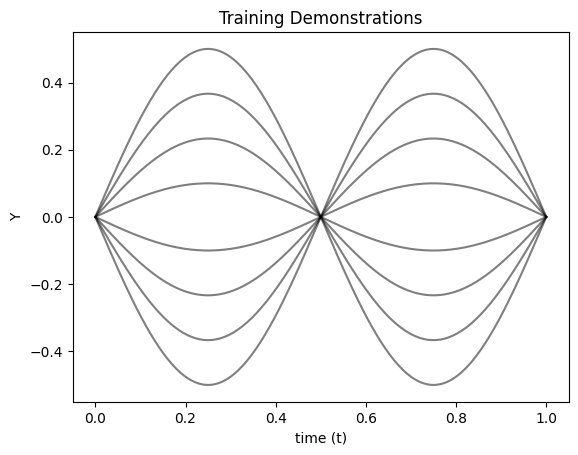

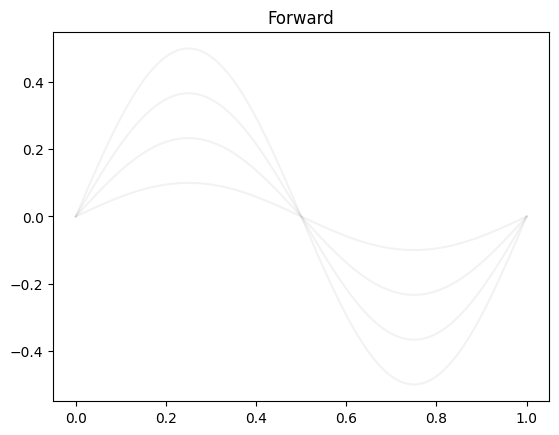

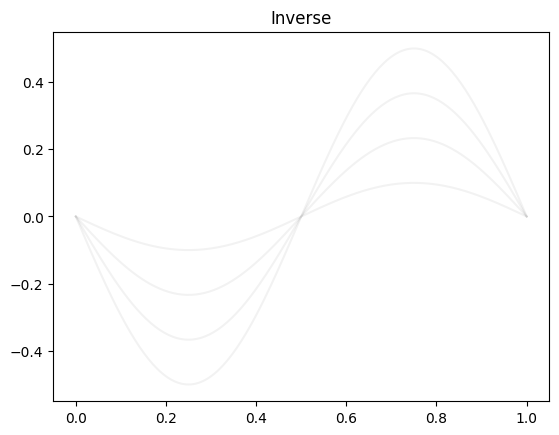

In [274]:
from cProfile import label
from re import X
from turtle import color
from sympy import li
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
import importlib

import dual_enc_dec_cnmp as dual_enc_dec_cnmp
import utils
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

#params = np.array([[2,0],[2,0],[2,0],[2,0],[2,0],[-0.6,0.1],[-0.55, 0.16],[-0.5,0.23],[-0.45, 0.33],[-0.4,0.43]])
params = np.array([[20],[19.9],[19.7]])

num_demo = 4
X1, X2, Y1, Y2, validation_Y1, validation_Y2 = utils.generate_demonstrations(num_demo, time_len=200, params = params, plot_title='Training')

In [278]:
demo_data = [X1, X2, Y1, Y2]
d_x = 1
d_y1 = 1
d_y2 = 1
OBS_MAX = 5
d_N = num_demo
time_len = 200

validation_indices_1 = [i+1 for i in range(0, num_demo-1, 7)]
validation_indices_2 = [i+2 for i in range(0, num_demo-2, 7)]
validation_indices = validation_indices_1 + validation_indices_2

## convert to tensor, use sourceTensor.clone().detach() to get a new tensor
X1 = torch.tensor(X1, dtype=torch.float32)
X2 = torch.tensor(X2, dtype=torch.float32)
Y1 = torch.tensor(Y1, dtype=torch.float32)
Y2 = torch.tensor(Y2, dtype=torch.float32)
validation_Y1 = torch.tensor(validation_Y1, dtype=torch.float32)
validation_Y2 = torch.tensor(validation_Y2, dtype=torch.float32)



/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_68091/2987545594.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X1 = torch.tensor(X1, dtype=torch.float32)
/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_68091/2987545594.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X2 = torch.tensor(X2, dtype=torch.float32)
/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_68091/2987545594.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y1 = torch.tensor(Y1, dtype=torch.float32)
/var/folders/63/kw9gvntx3hzf

In [279]:
from ftplib import error_perm


importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)


errors = []
losses = []
errors_with_latent = []

def train():

    model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def lr_lambda(epoch):
        if epoch < 1000:
            return 1e-4 / optimizer.defaults['lr']  # Scale factor for 1e-3
        elif 1000 <= epoch < 150000:
            return 1e-4 / optimizer.defaults['lr']  # Scale factor for 1e-4
        elif 150000 <= epoch < 300000:
            return 1e-5 / optimizer.defaults['lr']  # Scale factor for 1e-5
        else:
            return 1e-6 / optimizer.defaults['lr']
    
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    error = 0

    for i in range(EPOCHS):

        obs, mask, x_tar, y_tar_f, y_tar_i = dual_enc_dec_cnmp.get_training_sample(validation_indices, X1, Y1, X2, Y2, OBS_MAX, d_N, d_x, d_y1, d_y2, time_len)
        optimizer.zero_grad()
        output, L_F, L_I = model(obs, mask, x_tar)

        loss = dual_enc_dec_cnmp.loss(output, y_tar_f, y_tar_i, d_y1, d_y2, L_F.squeeze(1), L_I.squeeze(1))
        loss.backward()

        optimizer.step()
        scheduler.step()

        # VALIDATION
        if i % 100 == 0:
            
            if i % 1000 == 0:

                losses.append(loss.item())
                
                # print(f'Epoch: {i}, Loss: {loss.item()}')
                error = 0
                plot_id = np.random.randint(0, len(validation_indices))
                for validation_idx in validation_indices:
                    time = np.linspace(0, 1, time_len)
                    # permute time
                    idx = np.random.permutation(time_len)
                    idx = idx[:OBS_MAX]
                    time = [time[i] for i in idx]
                    condition_points = [[t, Y1[validation_idx, i:i+1]] for t,i in zip(time, idx)]
                    means, stds = dual_enc_dec_cnmp.predict_inverse(model, validation_idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
                    if i % 10000 == 0 and validation_idx == validation_indices[plot_id]:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=True)
                    else:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=False)

                    latent_loss = loss - dual_enc_dec_cnmp.log_prob_loss(output, y_tar_f, y_tar_i, d_y1, d_y2)
                error_with_latent = error + latent_loss.item()
                errors_with_latent.append(error_with_latent)
                errors.append(error)
                if errors[-1] == min(errors):
                    print('Saving model ', i)
                    print('loss: ', loss.item())  
                    print('latent loss: ', latent_loss.item())  
                    torch.save(model.state_dict(), 'inverse_best_model.pth')


torch.Size([4, 200, 1])
2


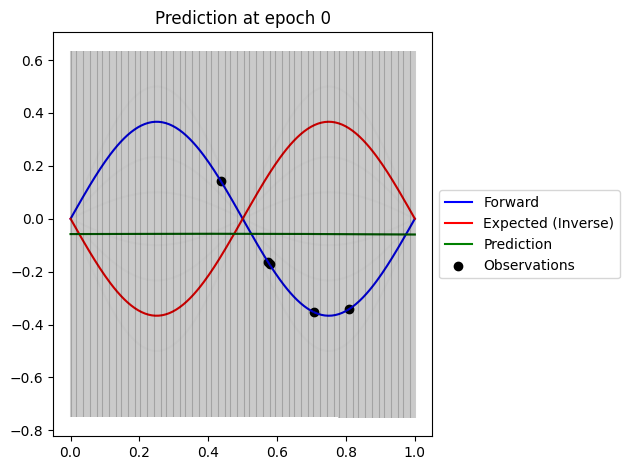

Saving model  0
loss:  32.014556884765625
latent loss:  30.913734436035156
Saving model  1000
loss:  2.5636894702911377
latent loss:  3.075809955596924
Saving model  2000
loss:  1.5405216217041016
latent loss:  2.965060234069824
Saving model  3000
loss:  1.0880271196365356
latent loss:  2.0635793209075928
Saving model  4000
loss:  1.0371918678283691
latent loss:  2.702794075012207
Saving model  5000
loss:  -0.8988199234008789
latent loss:  0.22141659259796143
Saving model  7000
loss:  -1.6626338958740234
latent loss:  0.20881402492523193
Saving model  8000
loss:  -0.4013035297393799
latent loss:  2.1634140014648438
Saving model  9000
loss:  5.750598907470703
latent loss:  7.739829063415527
torch.Size([4, 200, 1])
1


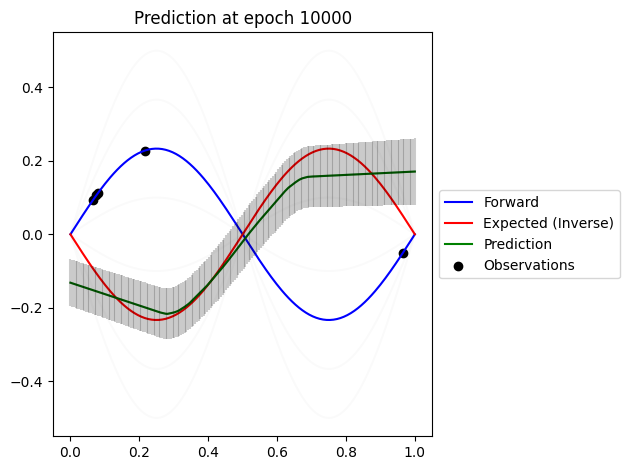

Saving model  10000
loss:  -1.6764283180236816
latent loss:  0.9154937267303467
Saving model  11000
loss:  -1.2044709920883179
latent loss:  1.728580117225647
Saving model  12000
loss:  0.016041278839111328
latent loss:  1.6045838594436646
Saving model  13000
loss:  -3.0202934741973877
latent loss:  0.29395270347595215
Saving model  14000
loss:  -1.9831199645996094
latent loss:  1.6049437522888184
Saving model  15000
loss:  -2.4400296211242676
latent loss:  0.5527424812316895
Saving model  16000
loss:  -3.1406731605529785
latent loss:  0.10534286499023438
Saving model  17000
loss:  -2.495690107345581
latent loss:  0.3947629928588867
Saving model  19000
loss:  -0.4585148096084595
latent loss:  1.9277375936508179
torch.Size([4, 200, 1])
2


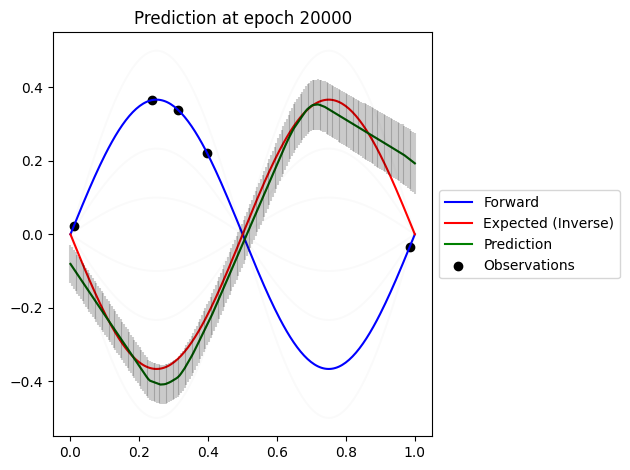

Saving model  21000
loss:  -4.233630657196045
latent loss:  0.4980196952819824
Saving model  22000
loss:  -4.612081527709961
latent loss:  0.5220303535461426
Saving model  23000
loss:  -1.3719890117645264
latent loss:  1.7847702503204346
Saving model  27000
loss:  -4.338022708892822
latent loss:  0.4083127975463867
Saving model  28000
loss:  -2.874929666519165
latent loss:  1.7596452236175537
torch.Size([4, 200, 1])
2


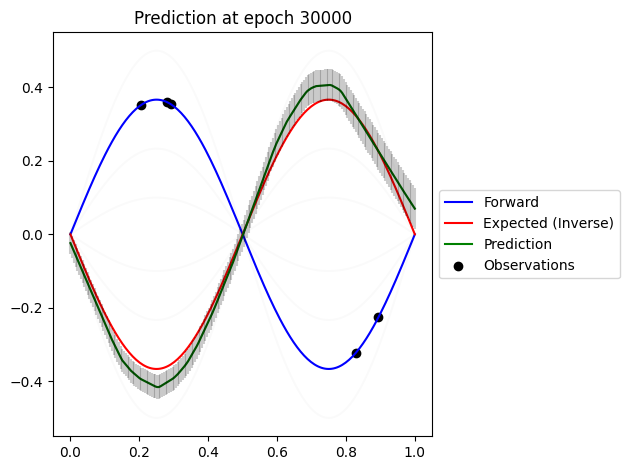

Saving model  31000
loss:  -2.1686887741088867
latent loss:  1.093252182006836
Saving model  34000
loss:  -4.4430742263793945
latent loss:  1.228623390197754
Saving model  37000
loss:  -5.739989280700684
latent loss:  0.568873405456543
torch.Size([4, 200, 1])
1


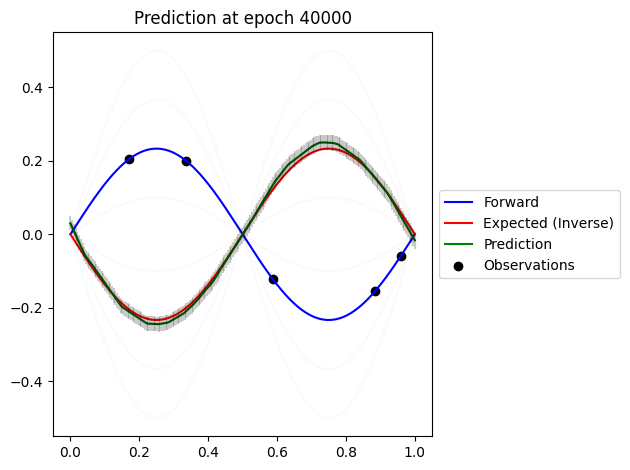

Saving model  41000
loss:  -4.7469401359558105
latent loss:  0.5012521743774414
Saving model  42000
loss:  -6.451536178588867
latent loss:  0.2945098876953125
torch.Size([4, 200, 1])
1


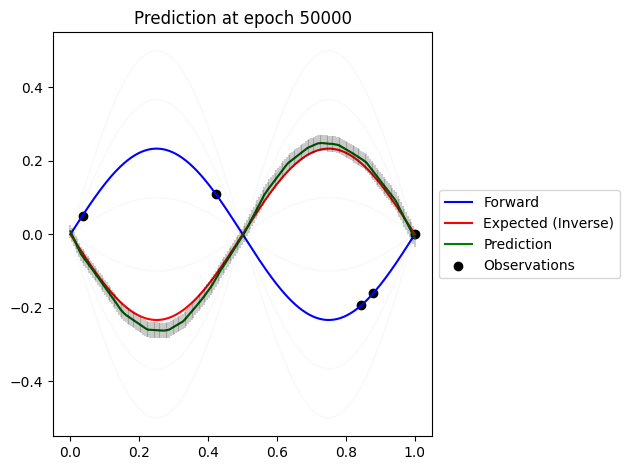

torch.Size([4, 200, 1])
2


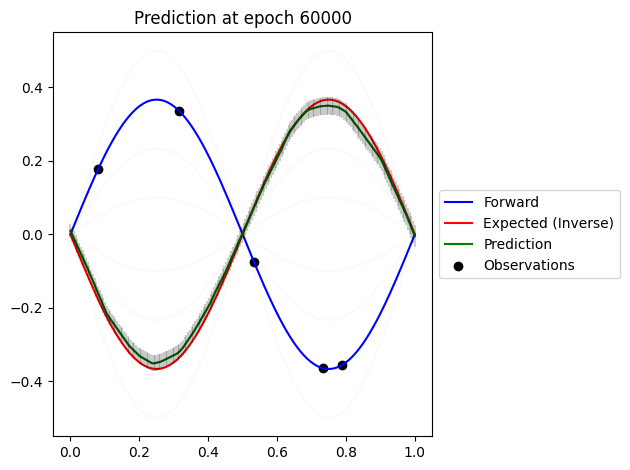

torch.Size([4, 200, 1])
2


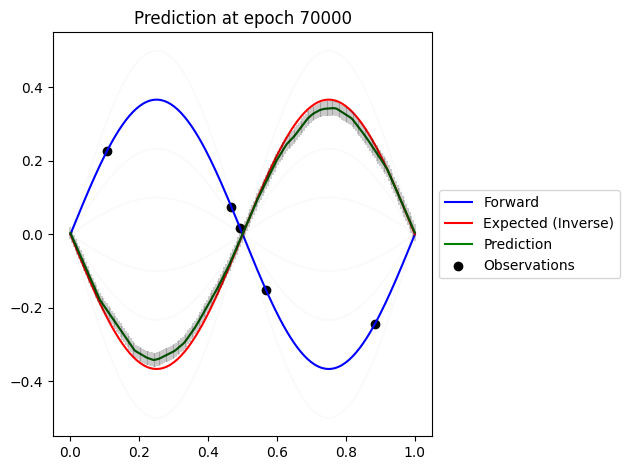

KeyboardInterrupt: 

In [280]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

EPOCHS = 500000
learning_rate = 1e-4

train()

In [281]:
best_model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2)
best_model.load_state_dict(torch.load('inverse_best_model.pth'))

/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_68091/1488616078.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('invers

<All keys matched successfully>

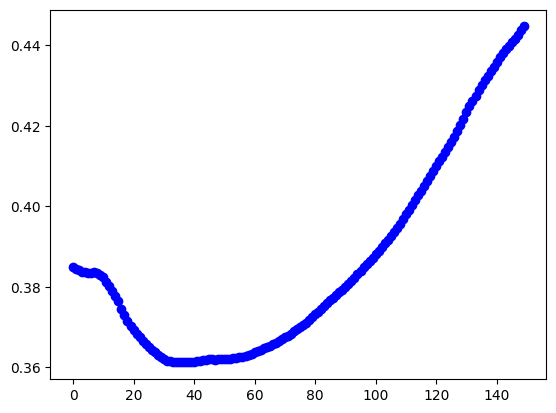

(300, 1, 128)
(300, 128)
(300, 2)


IndexError: index 2 is out of bounds for axis 0 with size 2

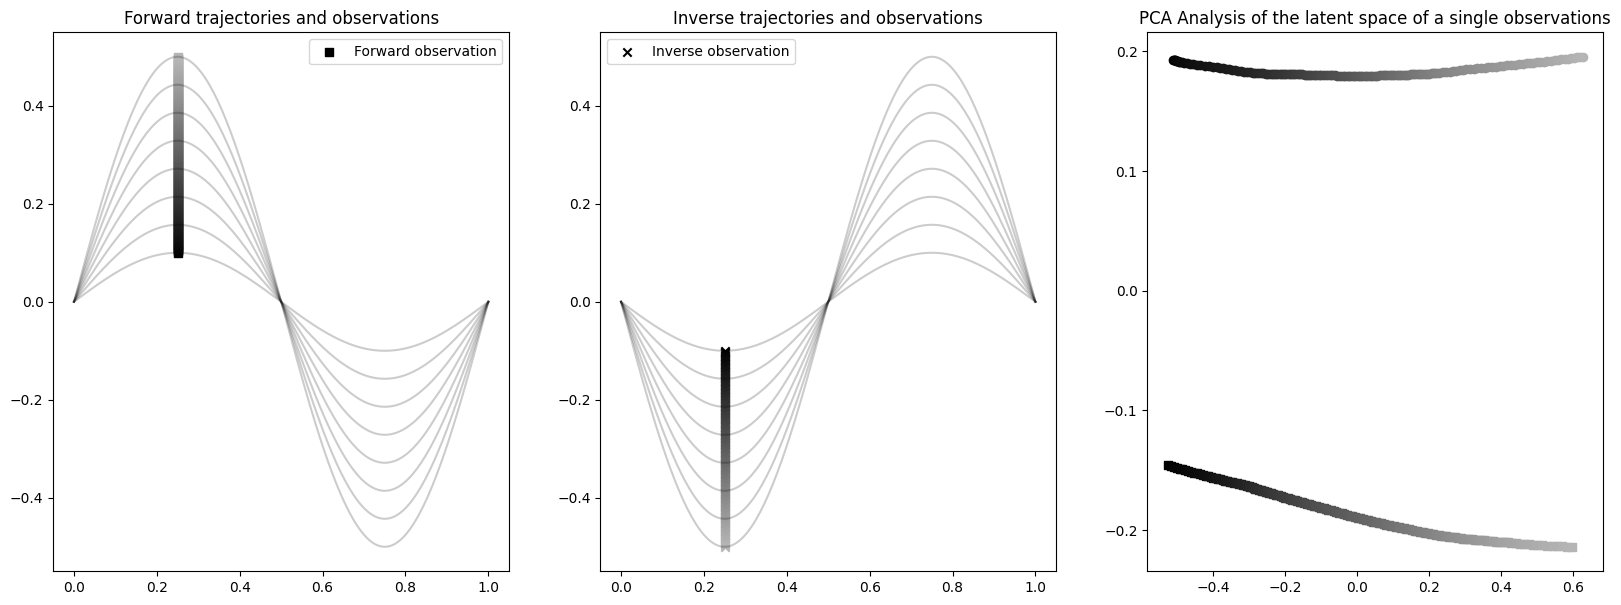

In [241]:

importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)
from mpl_toolkits.mplot3d import Axes3D
from sympy import intervals


time = [0.25]

## do the same for t = 0.25 and t = 0.75, obtain the pca result for all the points

intervals_y_f = []
intervals_y_i = []

all_observations_f = []  
all_observations_i = []

NUM_STEP = 150

for t in time:
    min_y_f = torch.min(Y1[:, int(t * time_len)])
    max_y_f = torch.max(Y1[:, int(t * time_len)])
    interval_y_f = torch.linspace(min_y_f, max_y_f, NUM_STEP)
    if t > 0.5:
        interval_y_f = torch.flip(interval_y_f, dims=[0])
    intervals_y_f.append(interval_y_f)

    min_y_i = torch.min(Y2[:, int(t * time_len)])
    max_y_i = torch.max(Y2[:, int(t * time_len)])
    interval_y_i = torch.linspace(min_y_i, max_y_i, NUM_STEP)
    if t < 0.5:
        interval_y_i = torch.flip(interval_y_i, dims=[0])
    intervals_y_i.append(interval_y_i)

    for idx in interval_y_f:
        condition_points = [[t, idx]]
        all_observations_f.append(condition_points)
    for idx in interval_y_i:
        condition_points = [[t, idx]]
        all_observations_i.append(condition_points)

all_observations_f = torch.tensor(all_observations_f)
all_observations_i = torch.tensor(all_observations_i)


pca_result = dual_enc_dec_cnmp.plot_latent_space(best_model, all_observations_f, all_observations_i) # [ft0, ft1, ... , it0, it1, ...]

## open 2 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 7))


for forward_traj in Y1:
    axs[0].plot(torch.linspace(0, 1, time_len), forward_traj, c='black', alpha=0.2)
for inverse_traj in Y2:
    axs[1].plot(torch.linspace(0, 1, time_len), inverse_traj, c='black', alpha=0.2)
axs[0].set_title("Forward trajectories and observations")
axs[1].set_title("Inverse trajectories and observations")

for i in range(len(intervals_y_f)):
    for j in range(len(intervals_y_f[i])):
        if i == 0 and j == 0:
            axs[0].scatter(time[i], intervals_y_f[i][j], marker="s", c=f"{(j)/(1.4*len(interval_y_f))}", label='Forward observation')
        else:
            if i == 0:
                axs[0].scatter(time[i], intervals_y_f[i][j], marker="s", c=f"{(j)/(1.4*len(interval_y_f))}")
            else:
                axs[0].scatter(time[i], intervals_y_f[i][j], c=f"{(j)/(1.4*len(interval_y_f))}")

for i in range(len(intervals_y_i)):
    for j in range(len(intervals_y_i[i])):
        if i == 0 and j == 0:
            axs[1].scatter(time[i], intervals_y_i[i][j], marker="x", c=f"{(j)/(1.4*len(interval_y_i))}", label='Inverse observation')
        else:
            if i == 0:
                axs[1].scatter(time[i], intervals_y_i[i][j], marker="x", c=f"{(j)/(1.4*len(interval_y_i))}")
            else:
                axs[1].scatter(time[i], intervals_y_i[i][j], marker="^", c=f"{(j)/(1.4*len(interval_y_i))}")

axs[0].legend()
axs[1].legend()

print(pca_result.shape)
pca_result = np.array(pca_result)
pca_result_f1 = pca_result[:NUM_STEP] 
#pca_result_f2 = pca_result[NUM_STEP:NUM_STEP*2]
pca_result_i1 = pca_result[NUM_STEP:]
#pca_result_i2 = pca_result[NUM_STEP*3:]

pca_result = np.array([pca_result_f1, pca_result_i1])

dict_markers = {0:'s', 1:'o', 2:'x', 3:'^'}

for i in range(4):
    for j in range(NUM_STEP):
        axs[2].scatter(pca_result[i, j, 0], pca_result[i, j, 1], marker=dict_markers[i], c=f"{(j)/(1.4*NUM_STEP)}")
    axs[2].set_title("PCA Analysis of the latent space of a single observations")

axs[2].axis('equal')
    
## make x and y axis equal

plt.title("PCA Analysis of the latent space of a single observations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



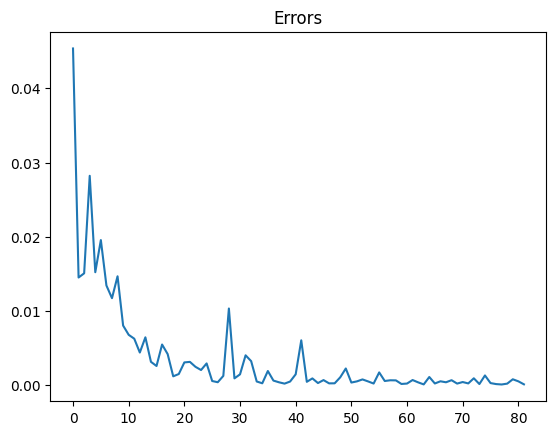

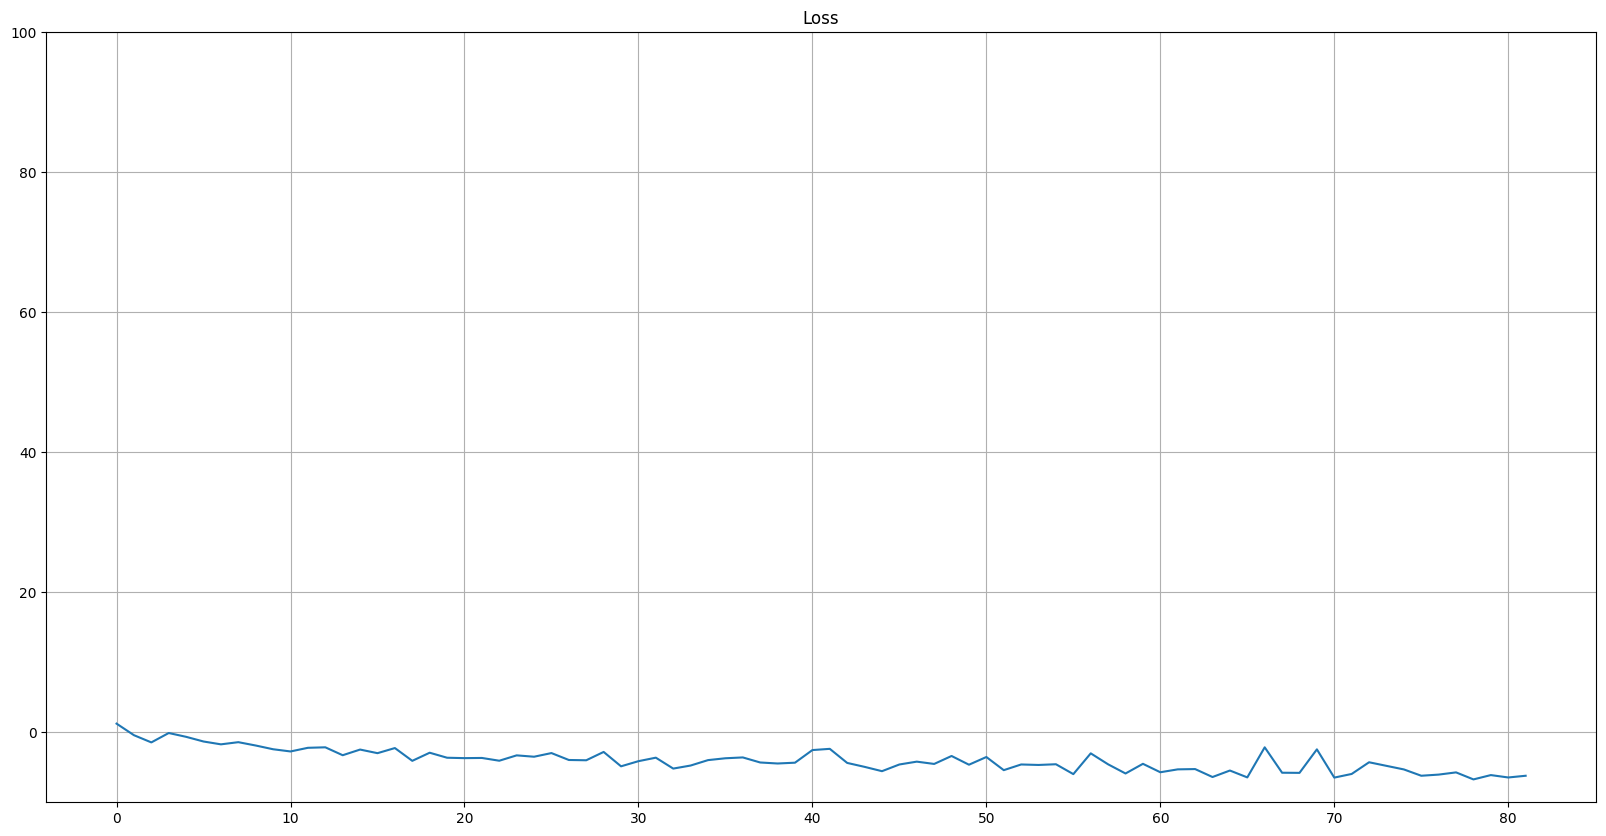

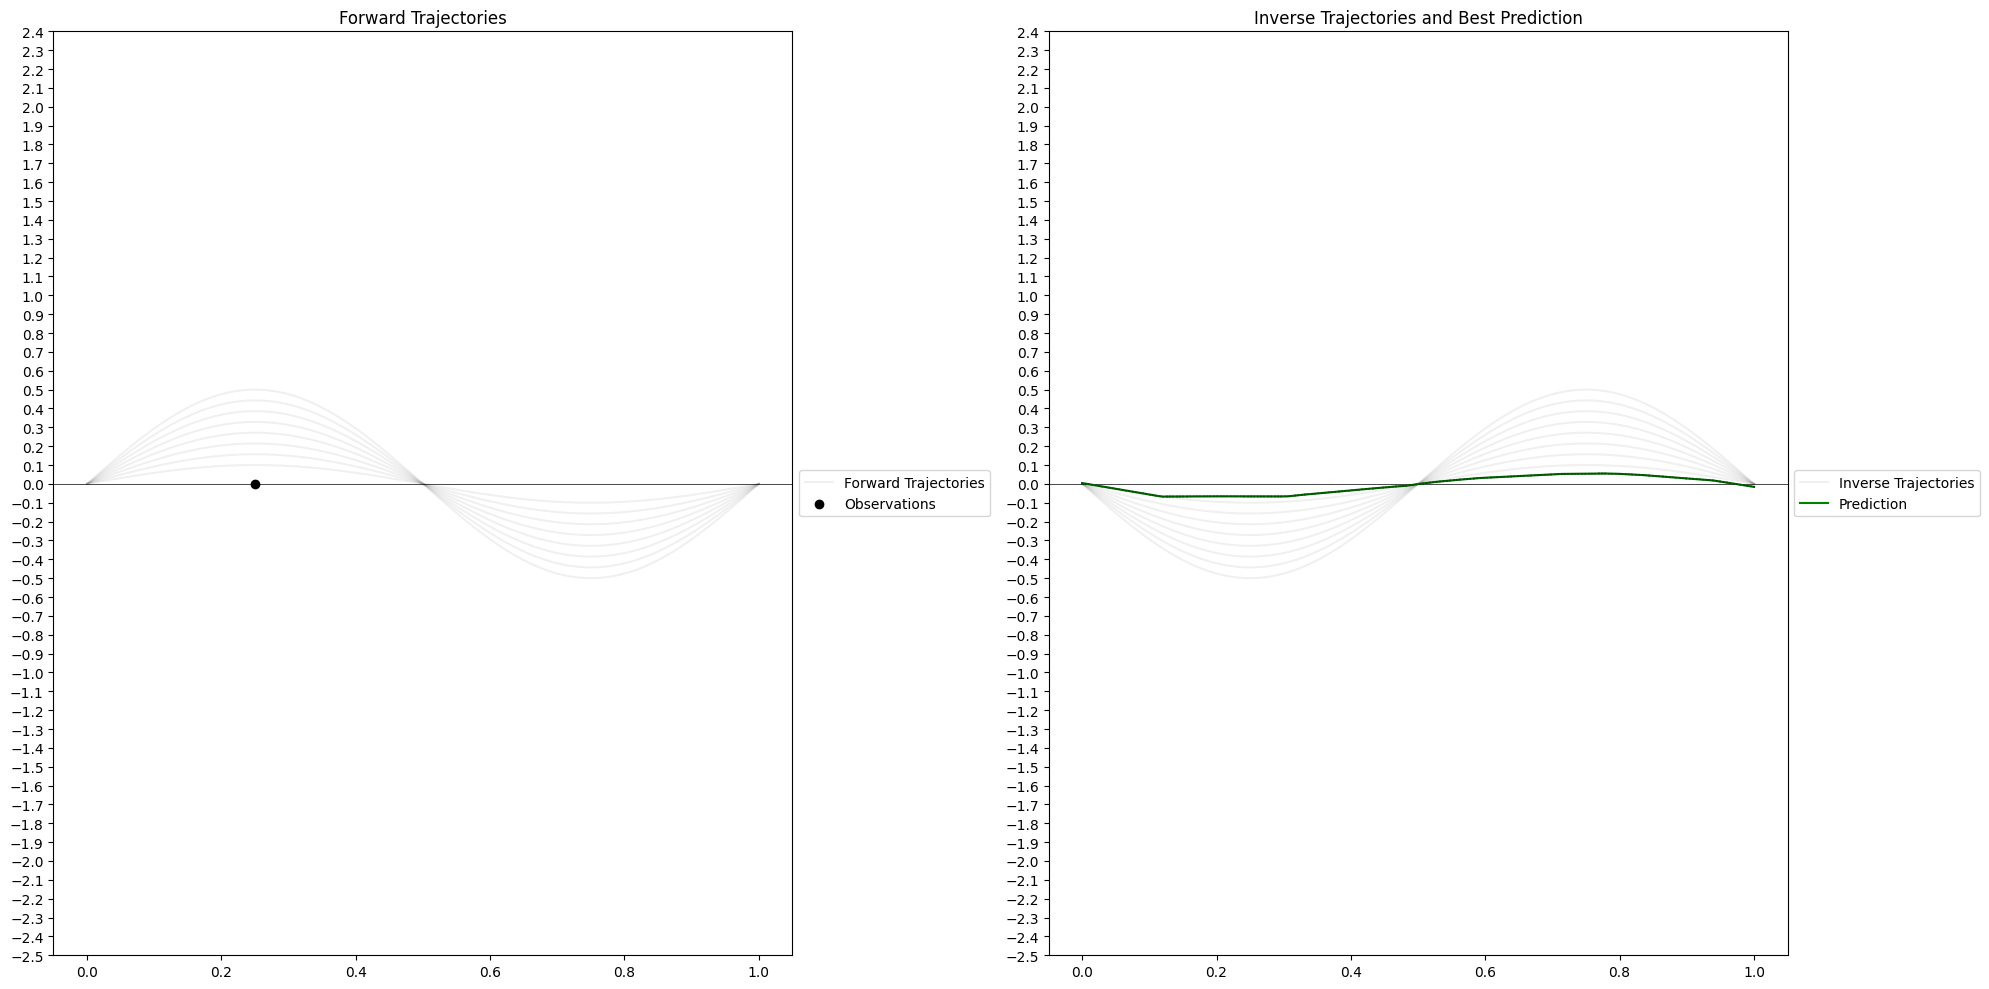

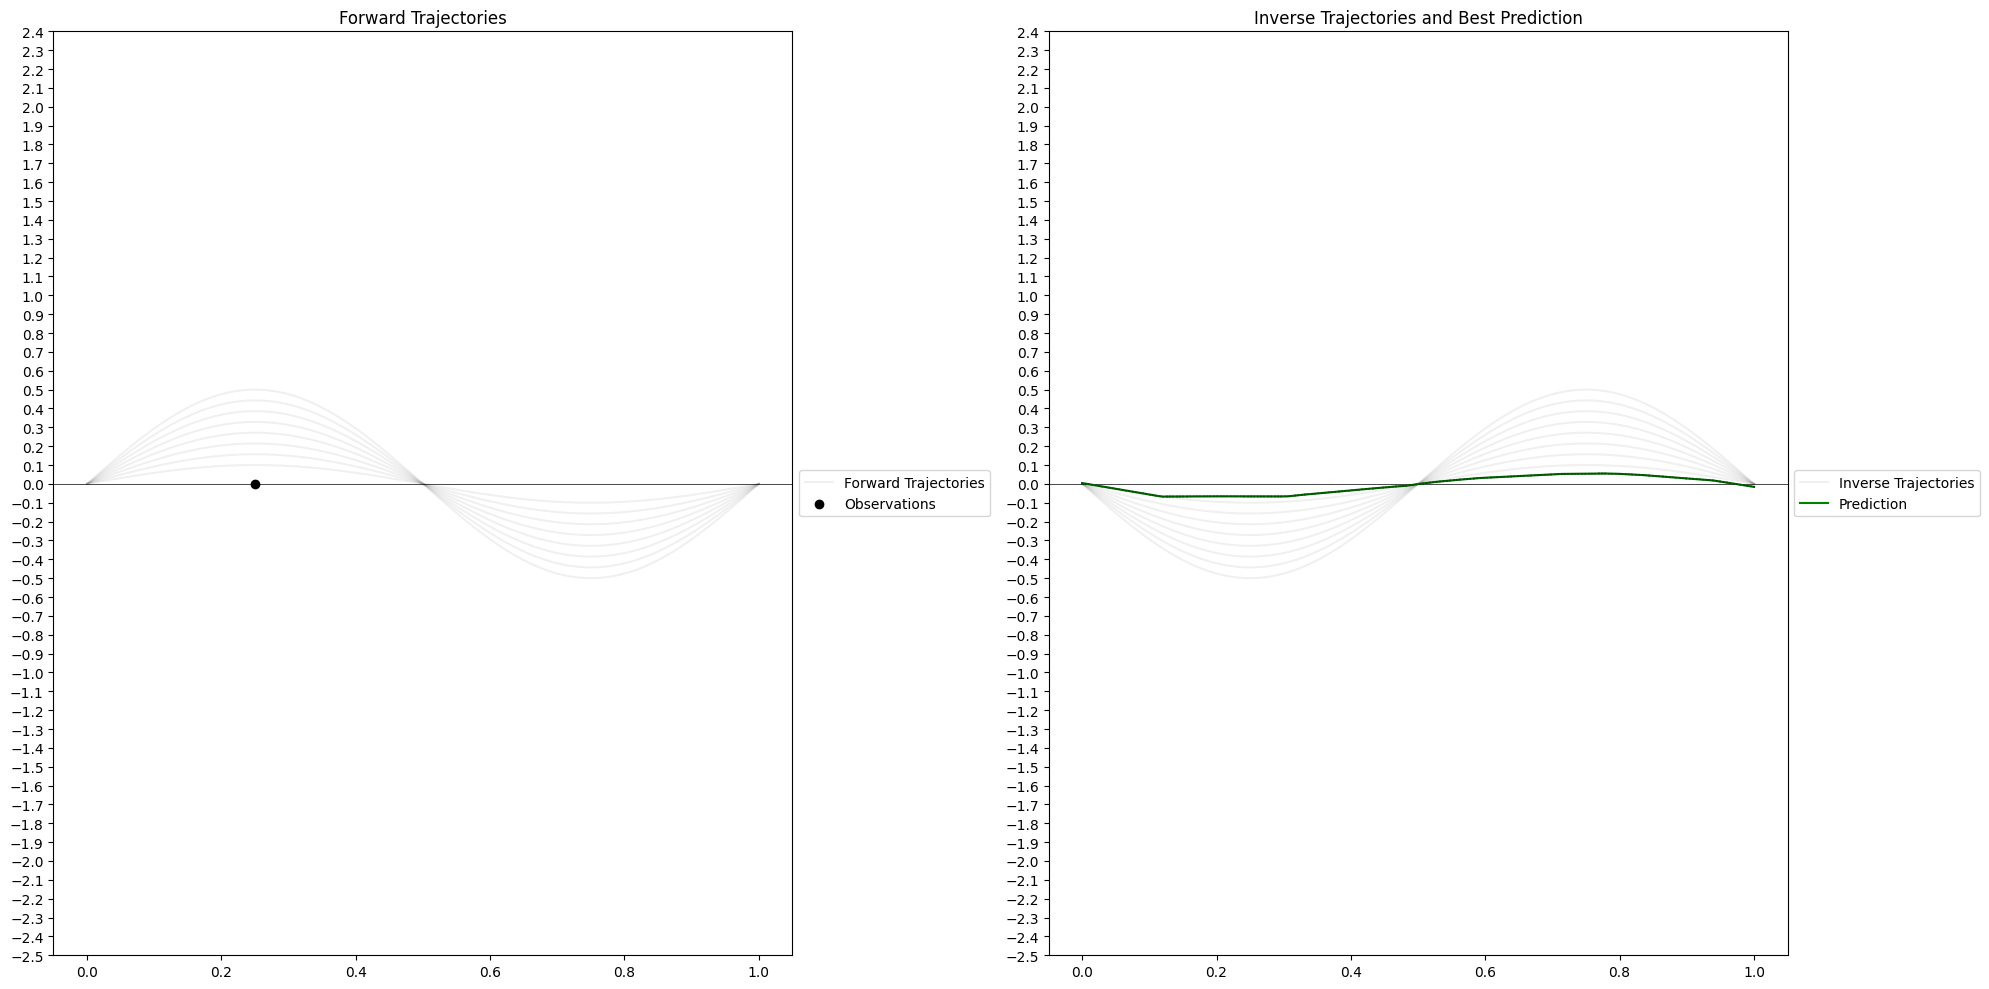

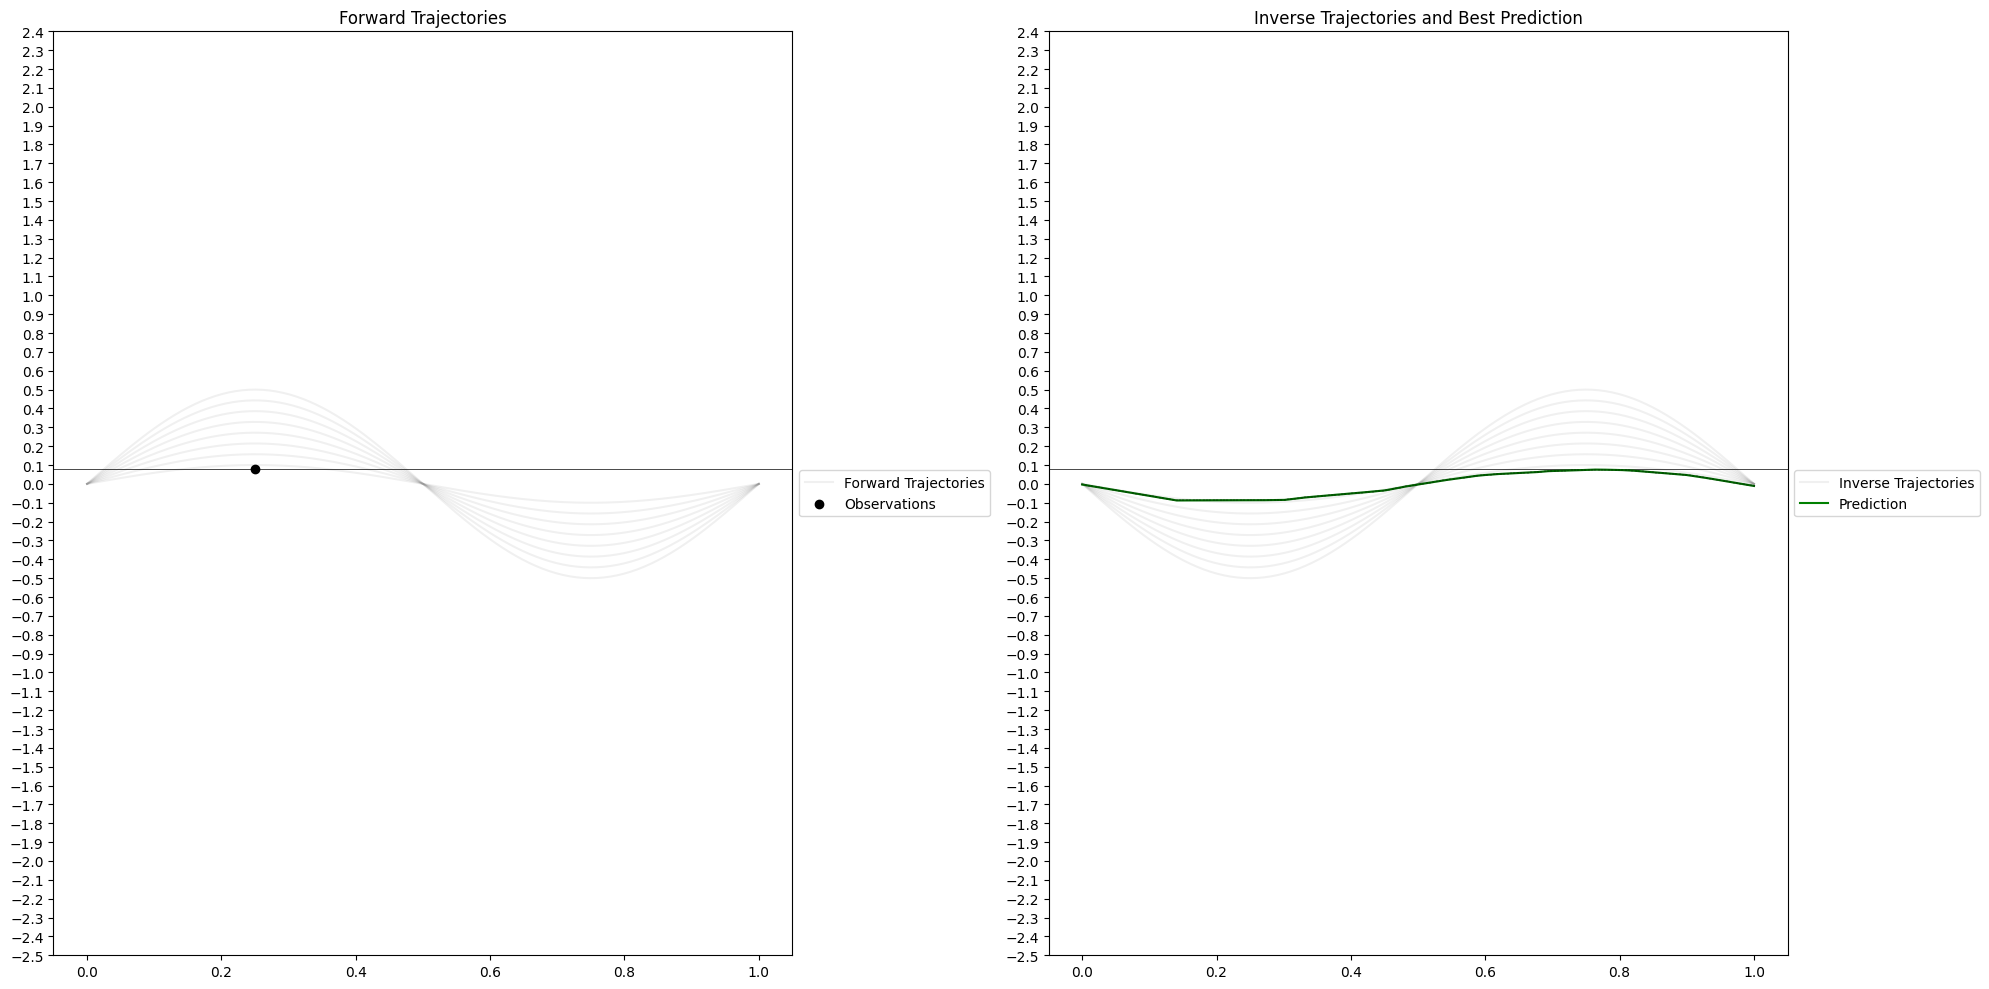

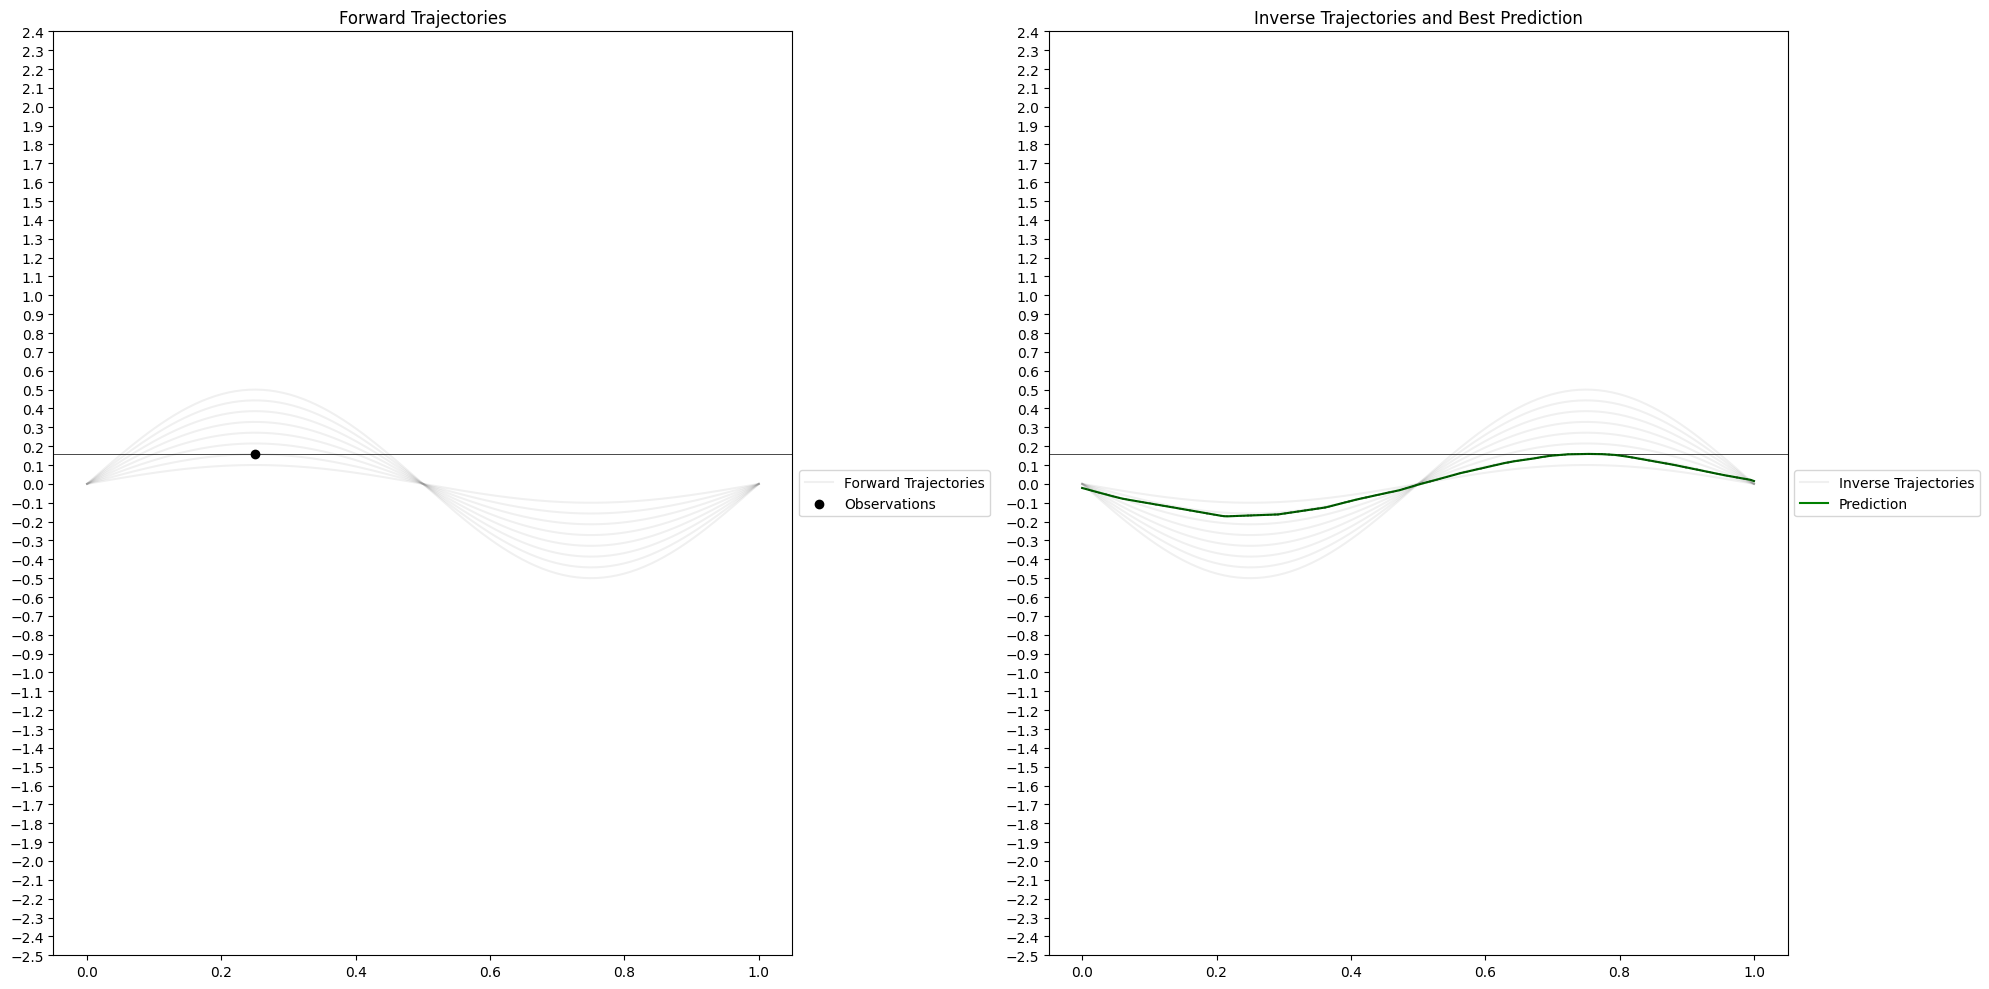

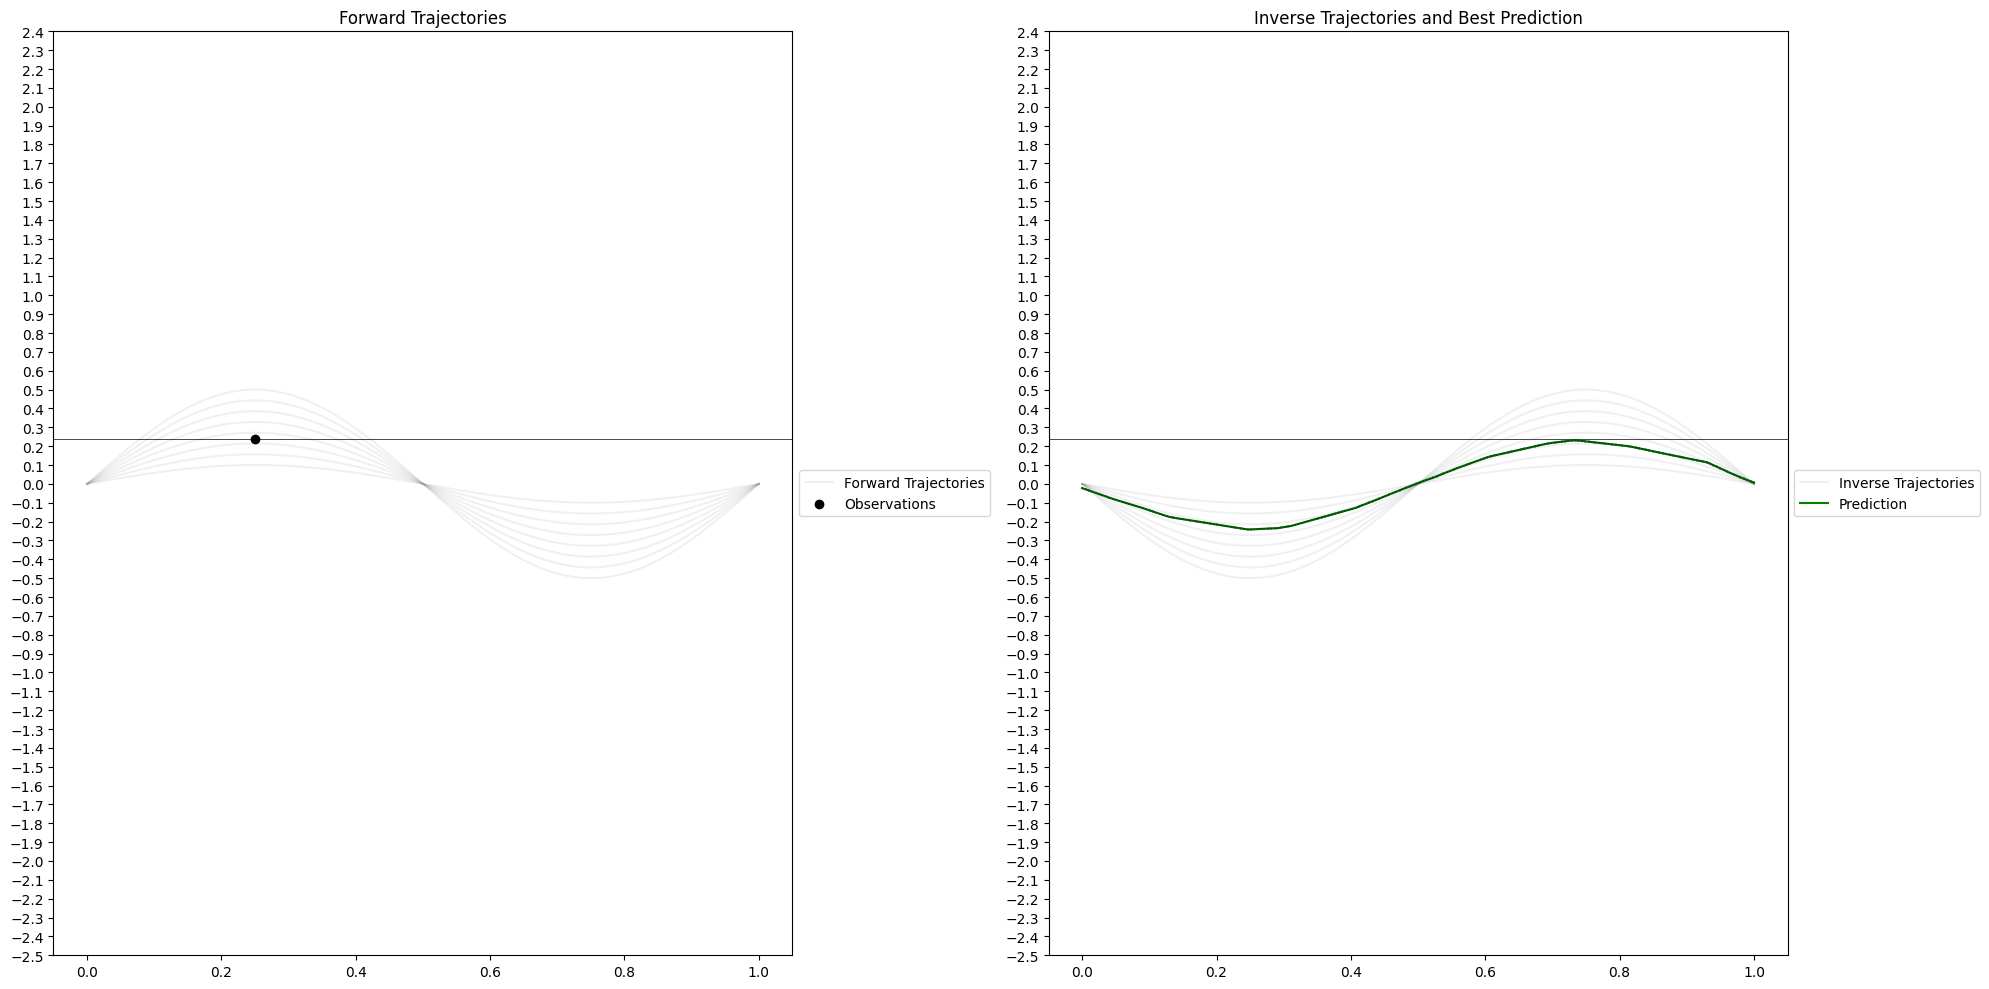

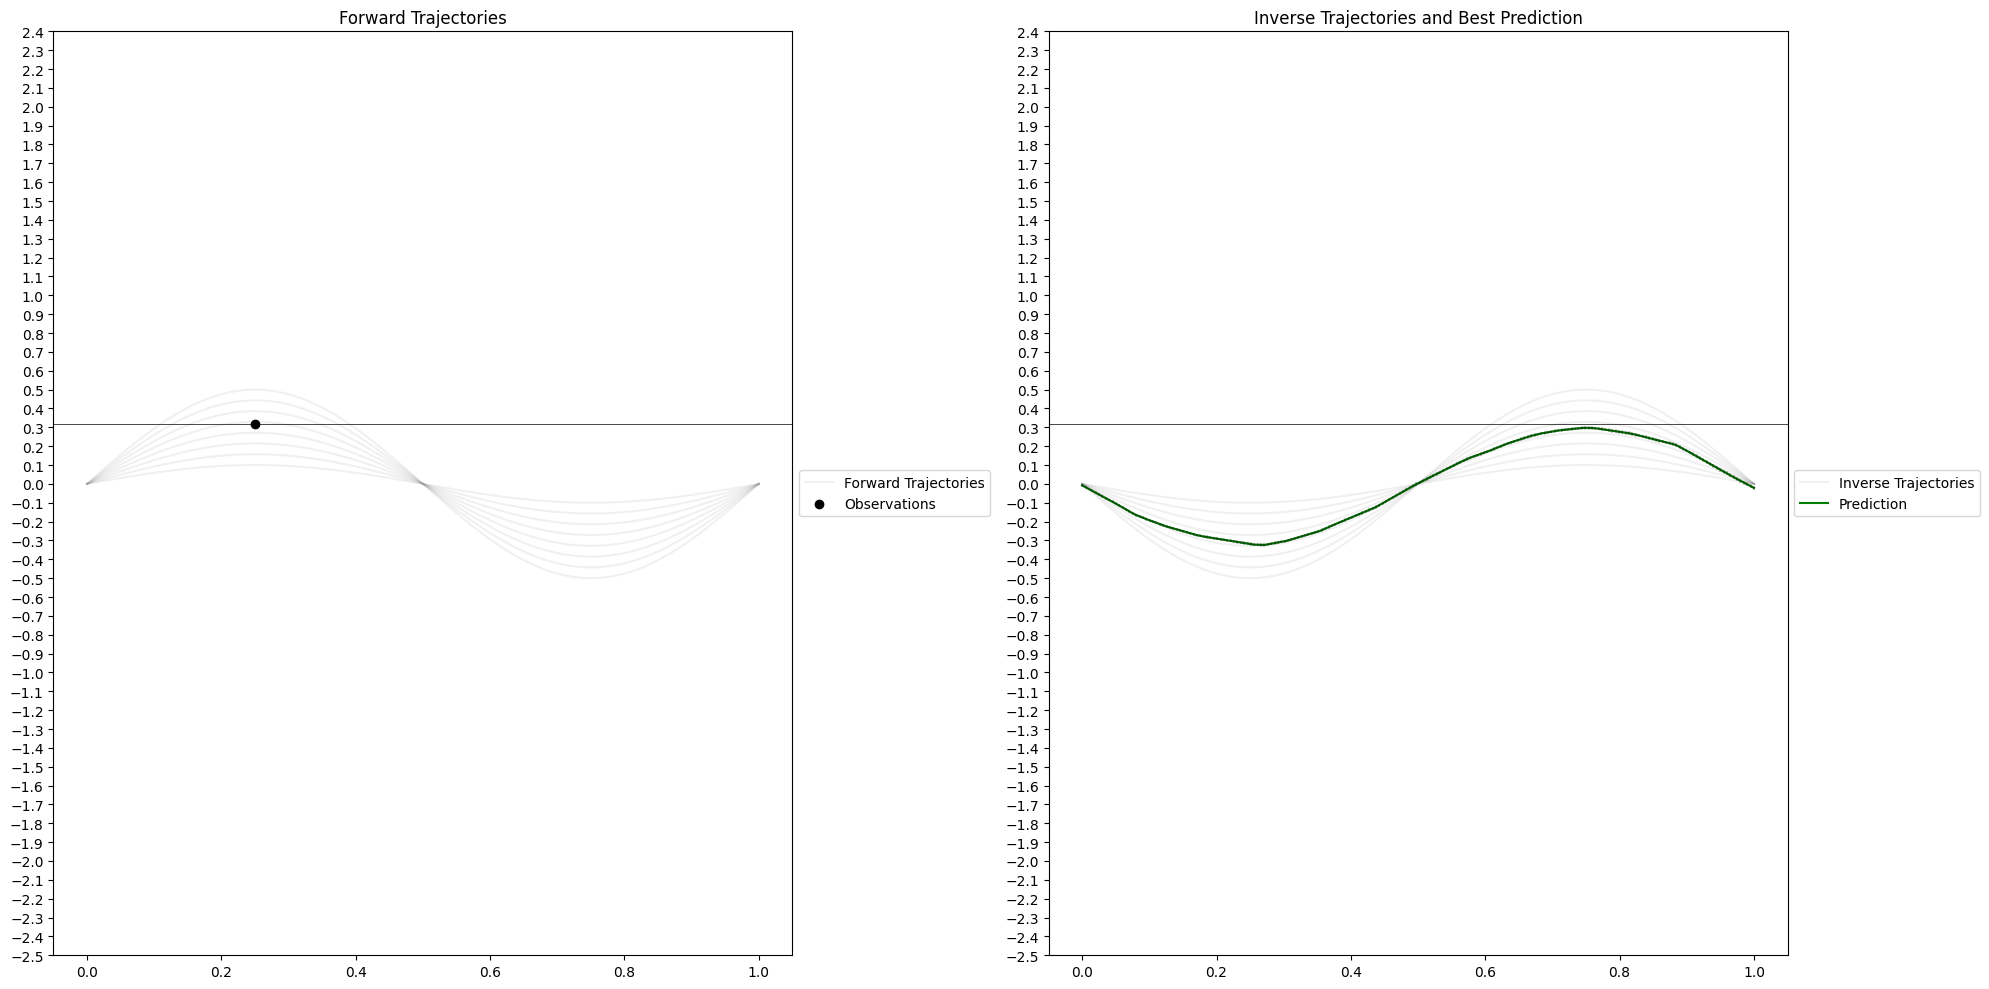

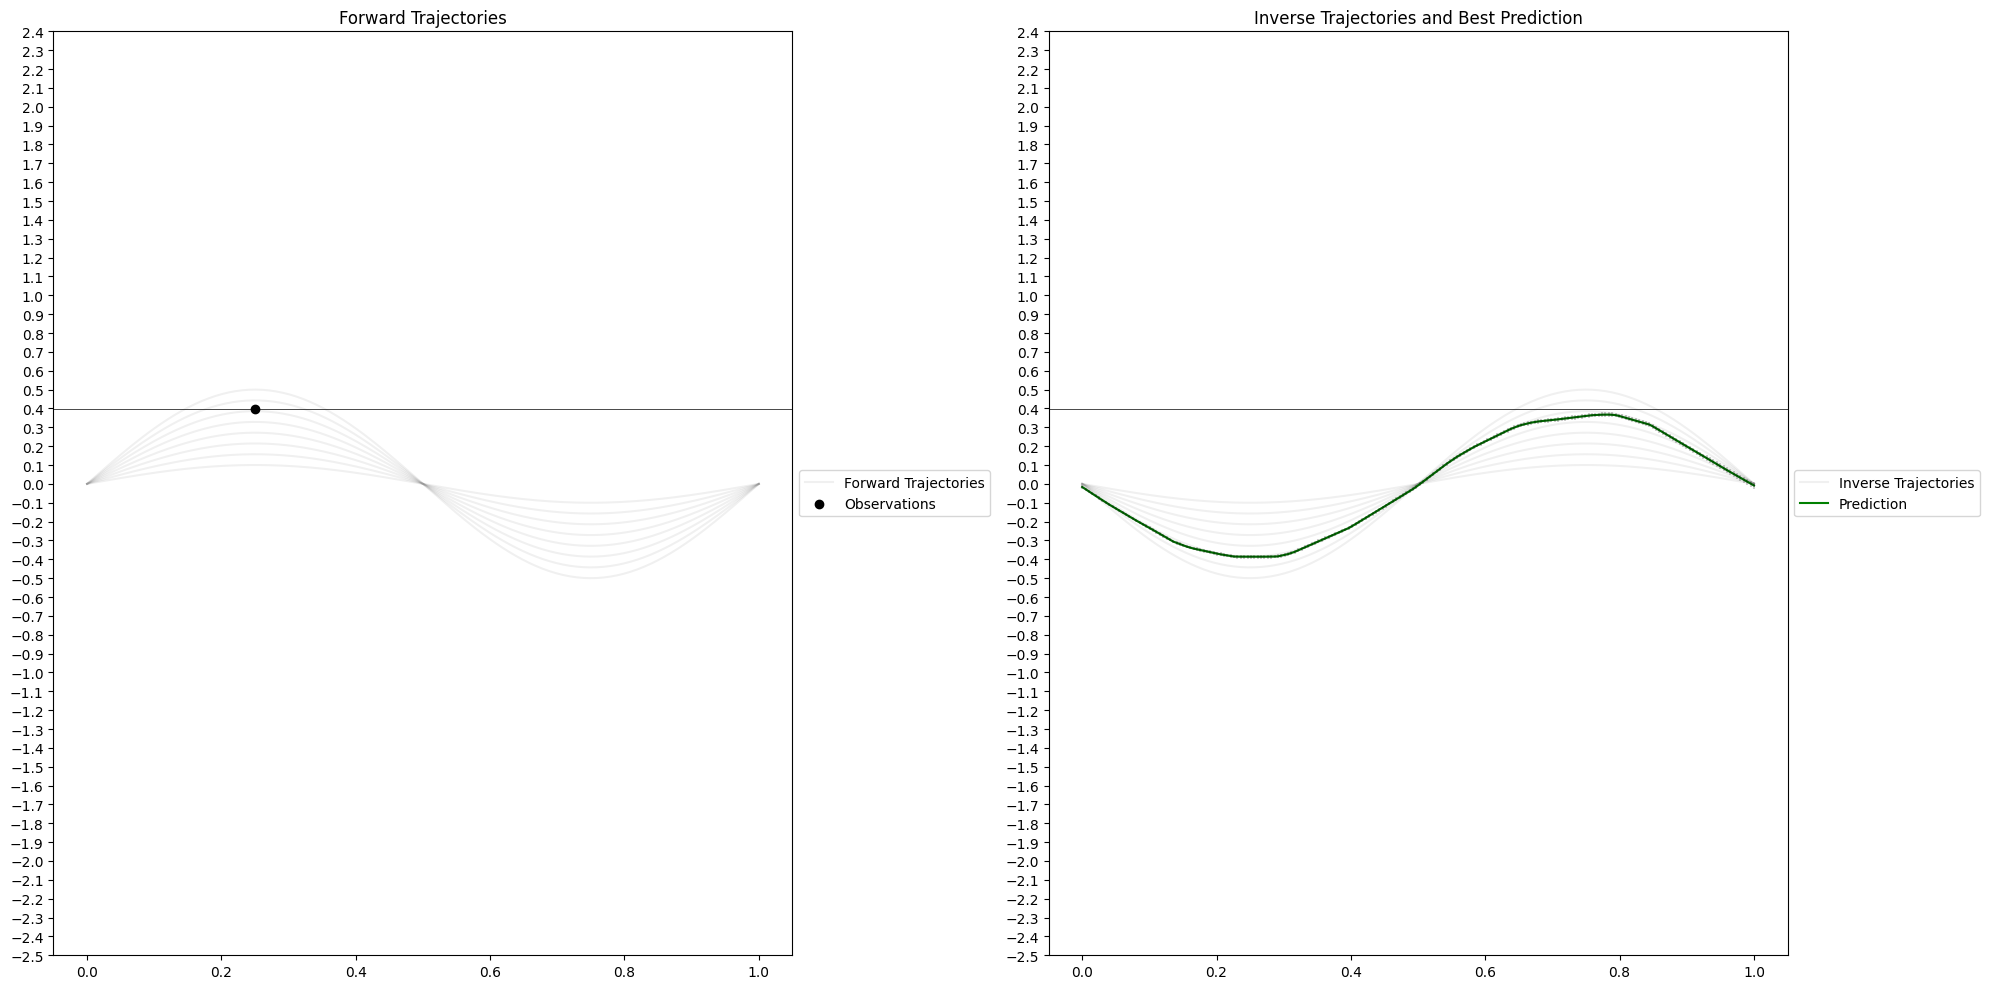

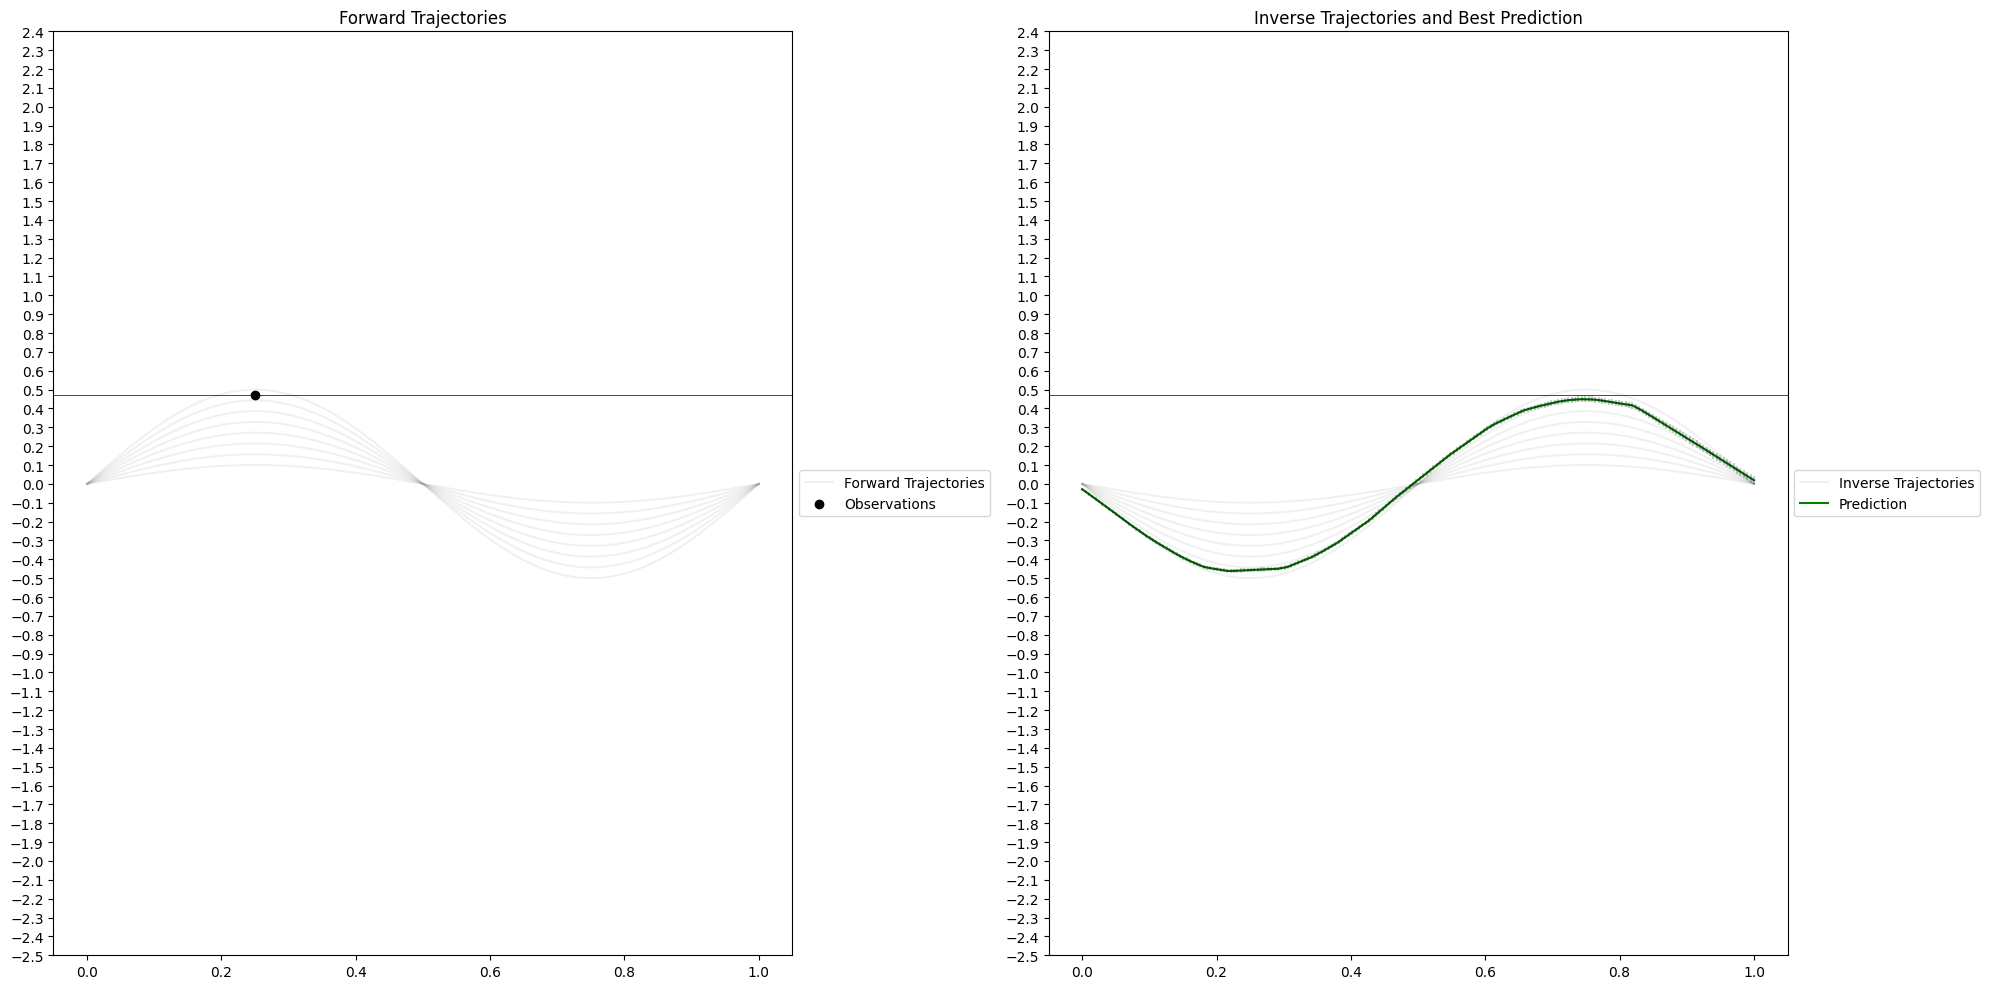

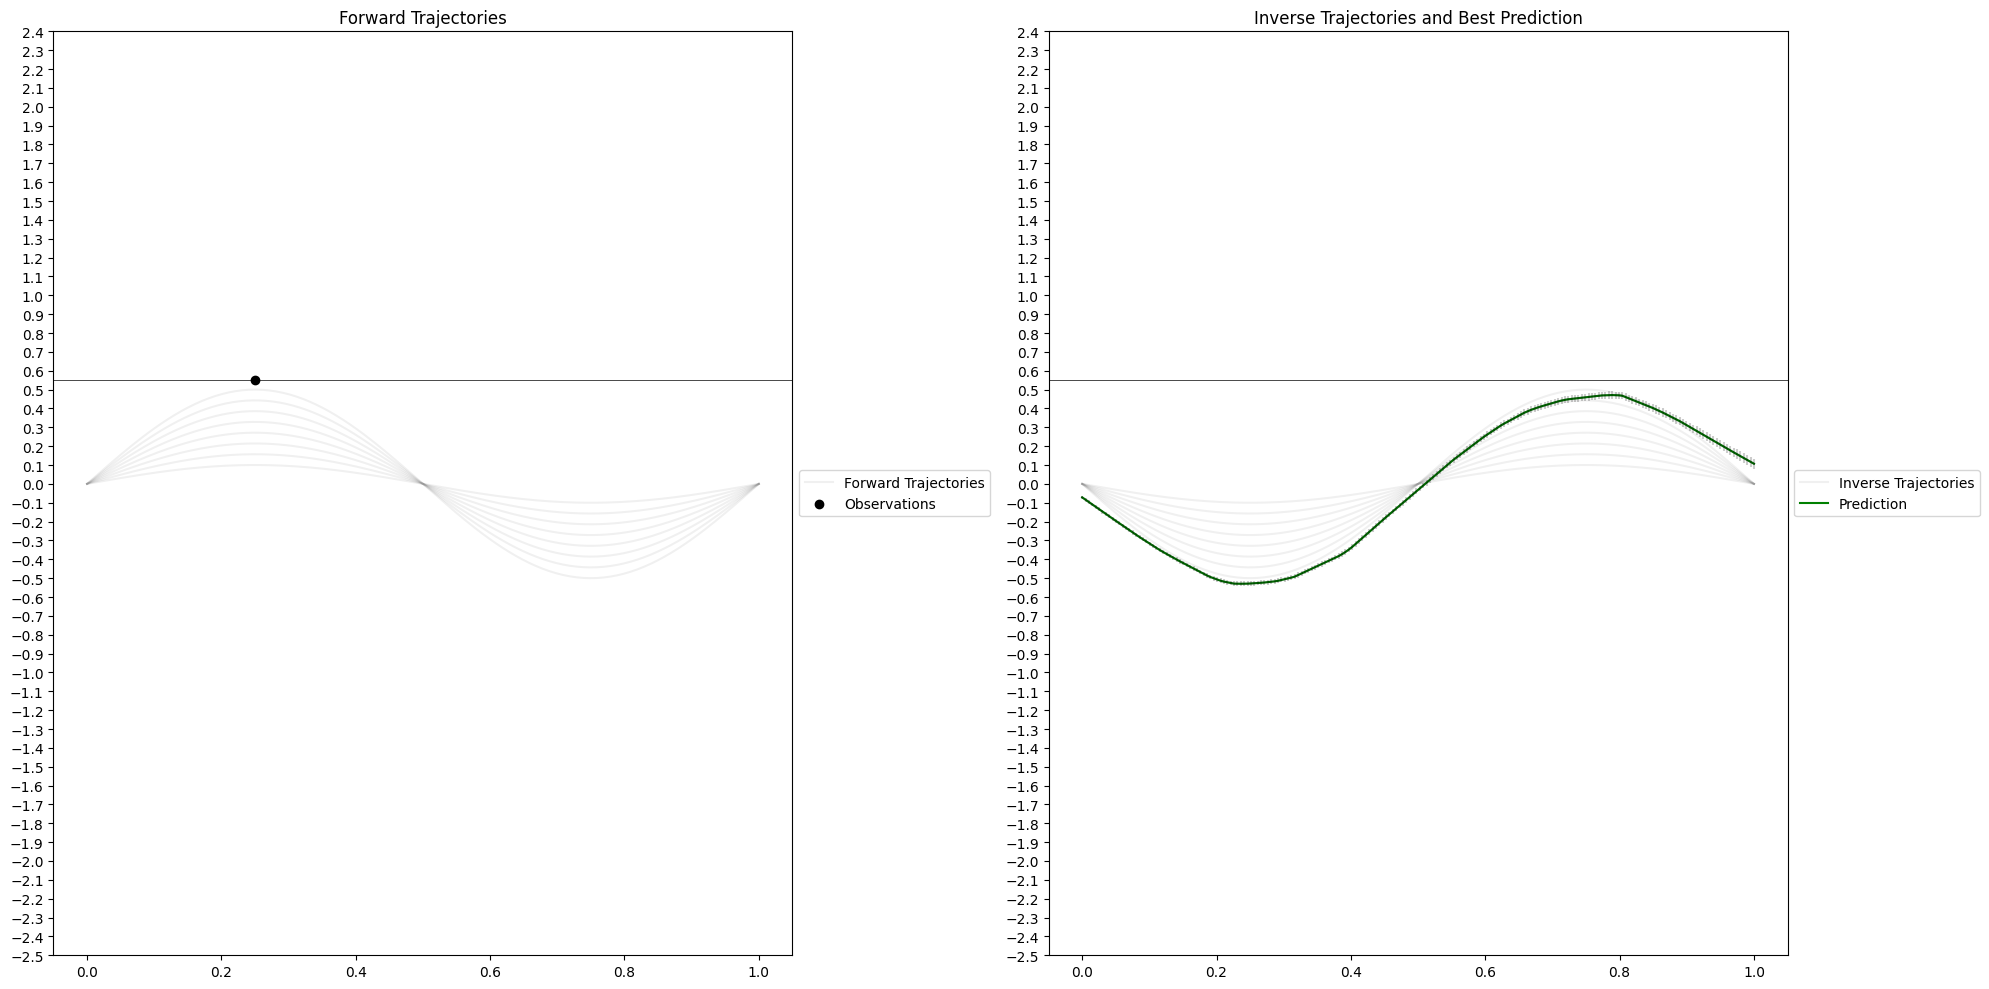

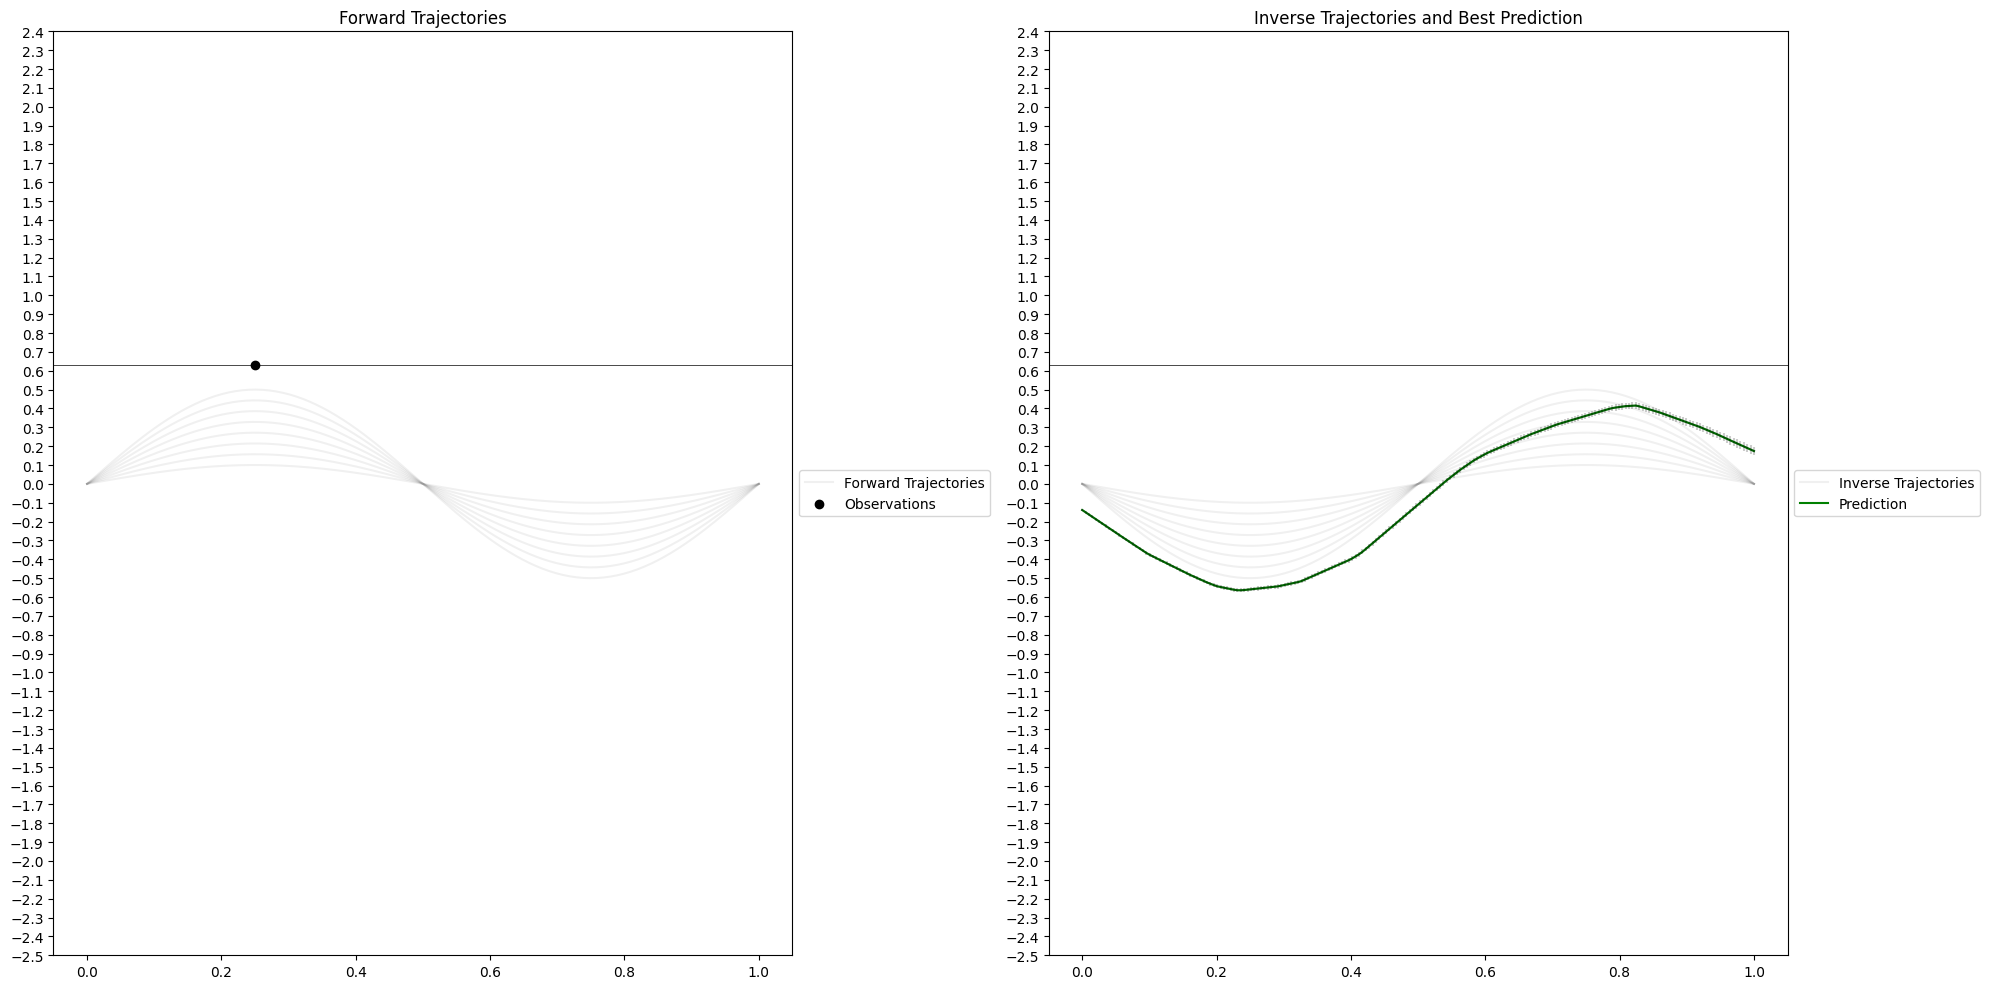

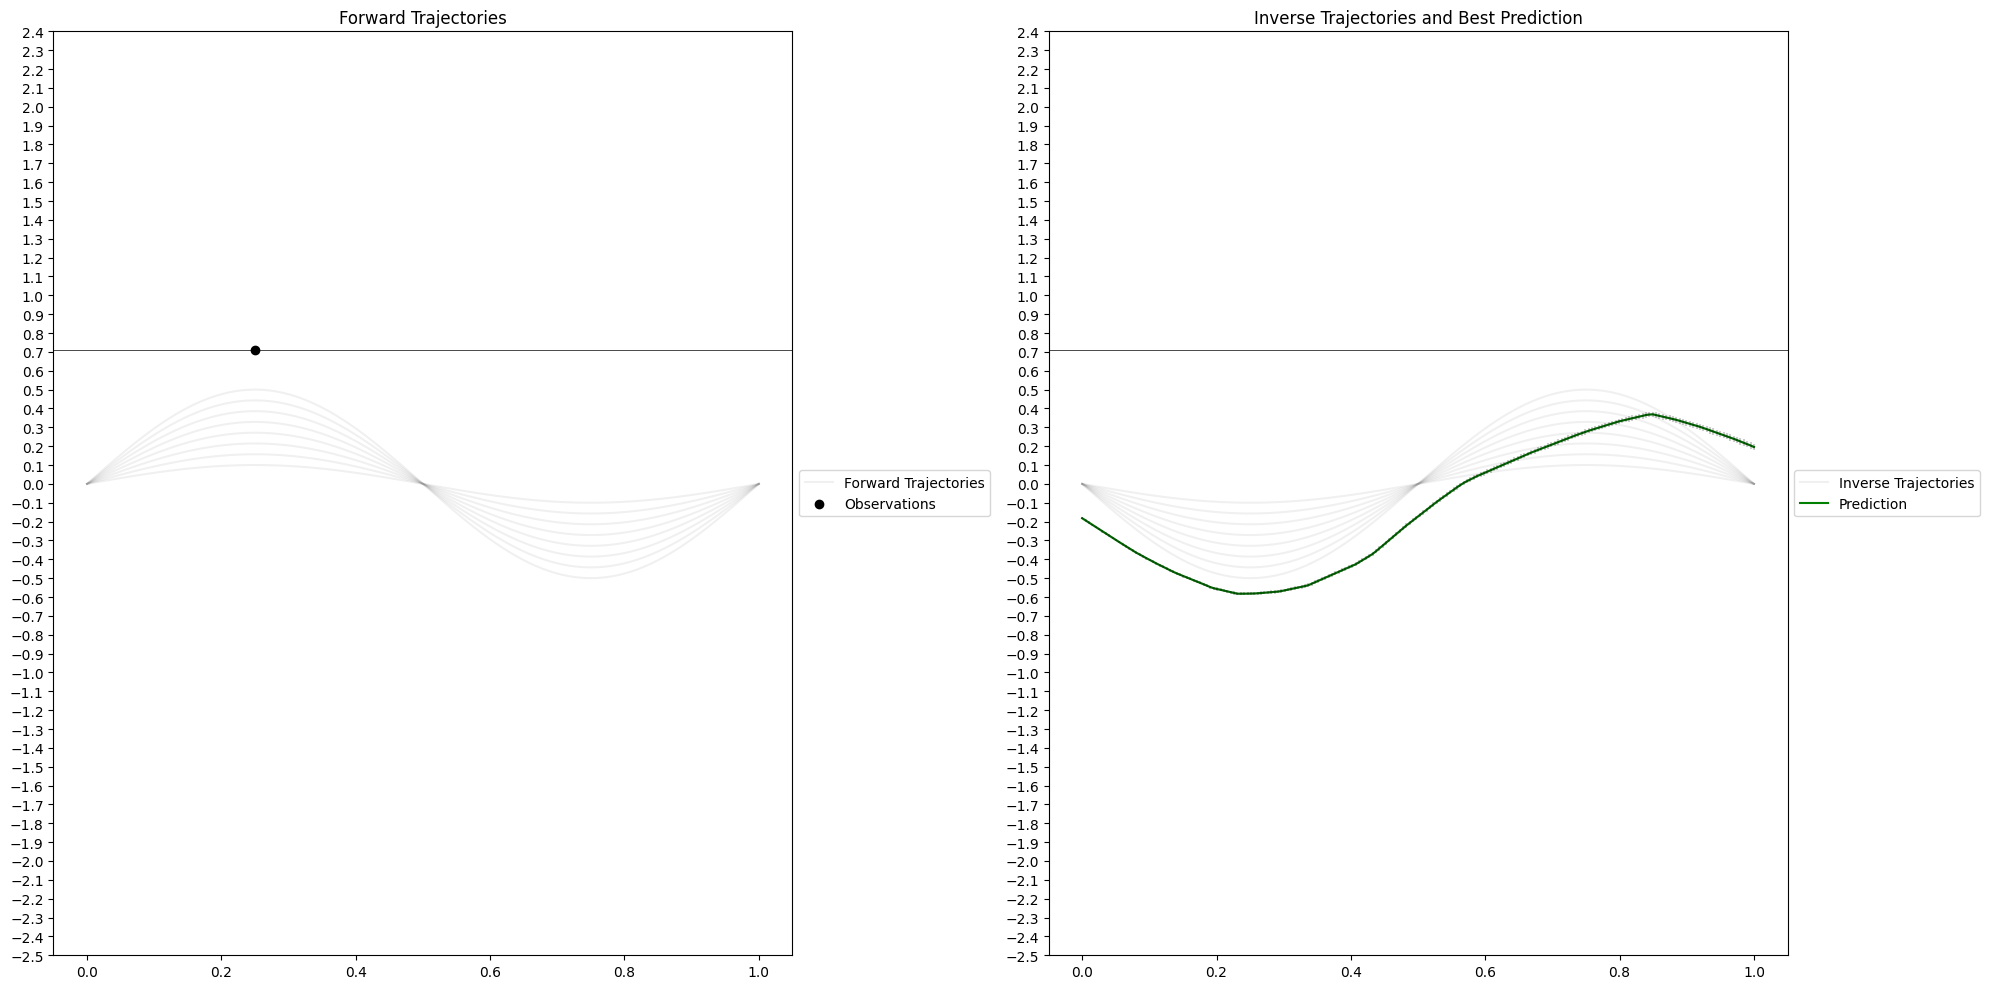

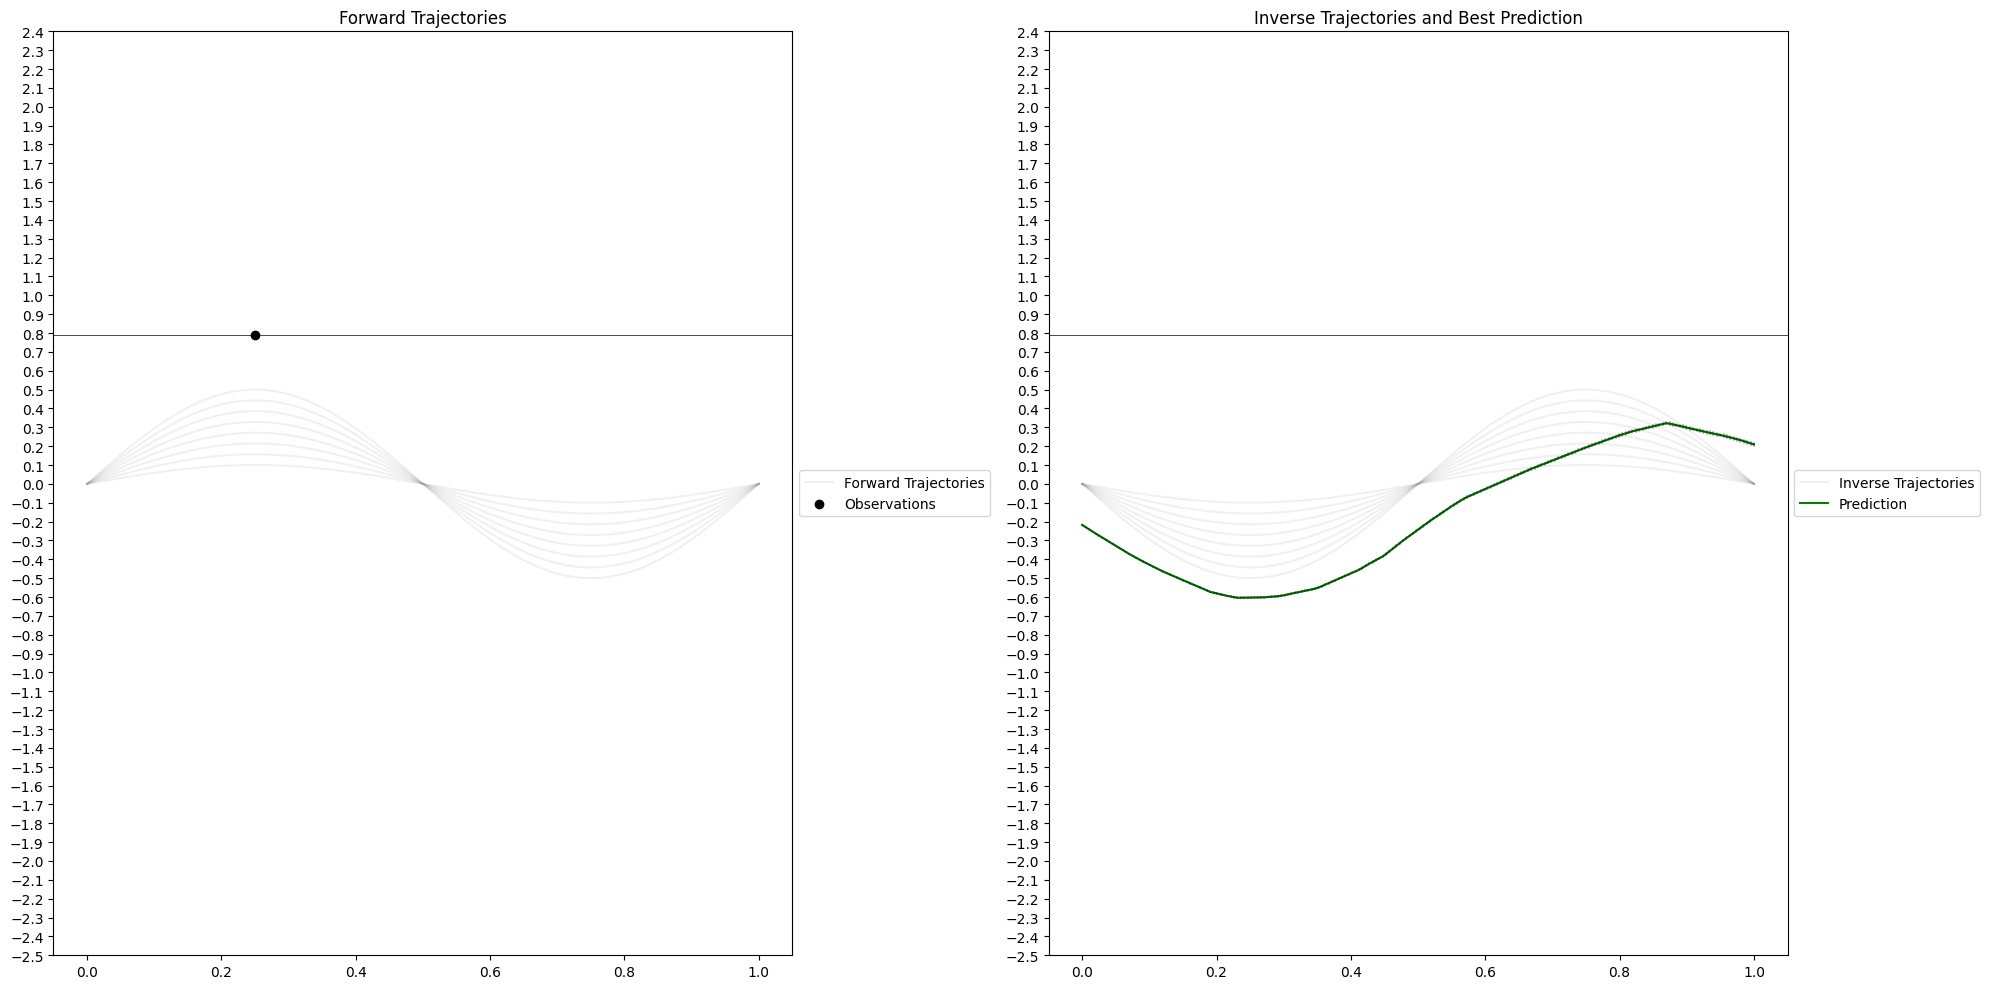

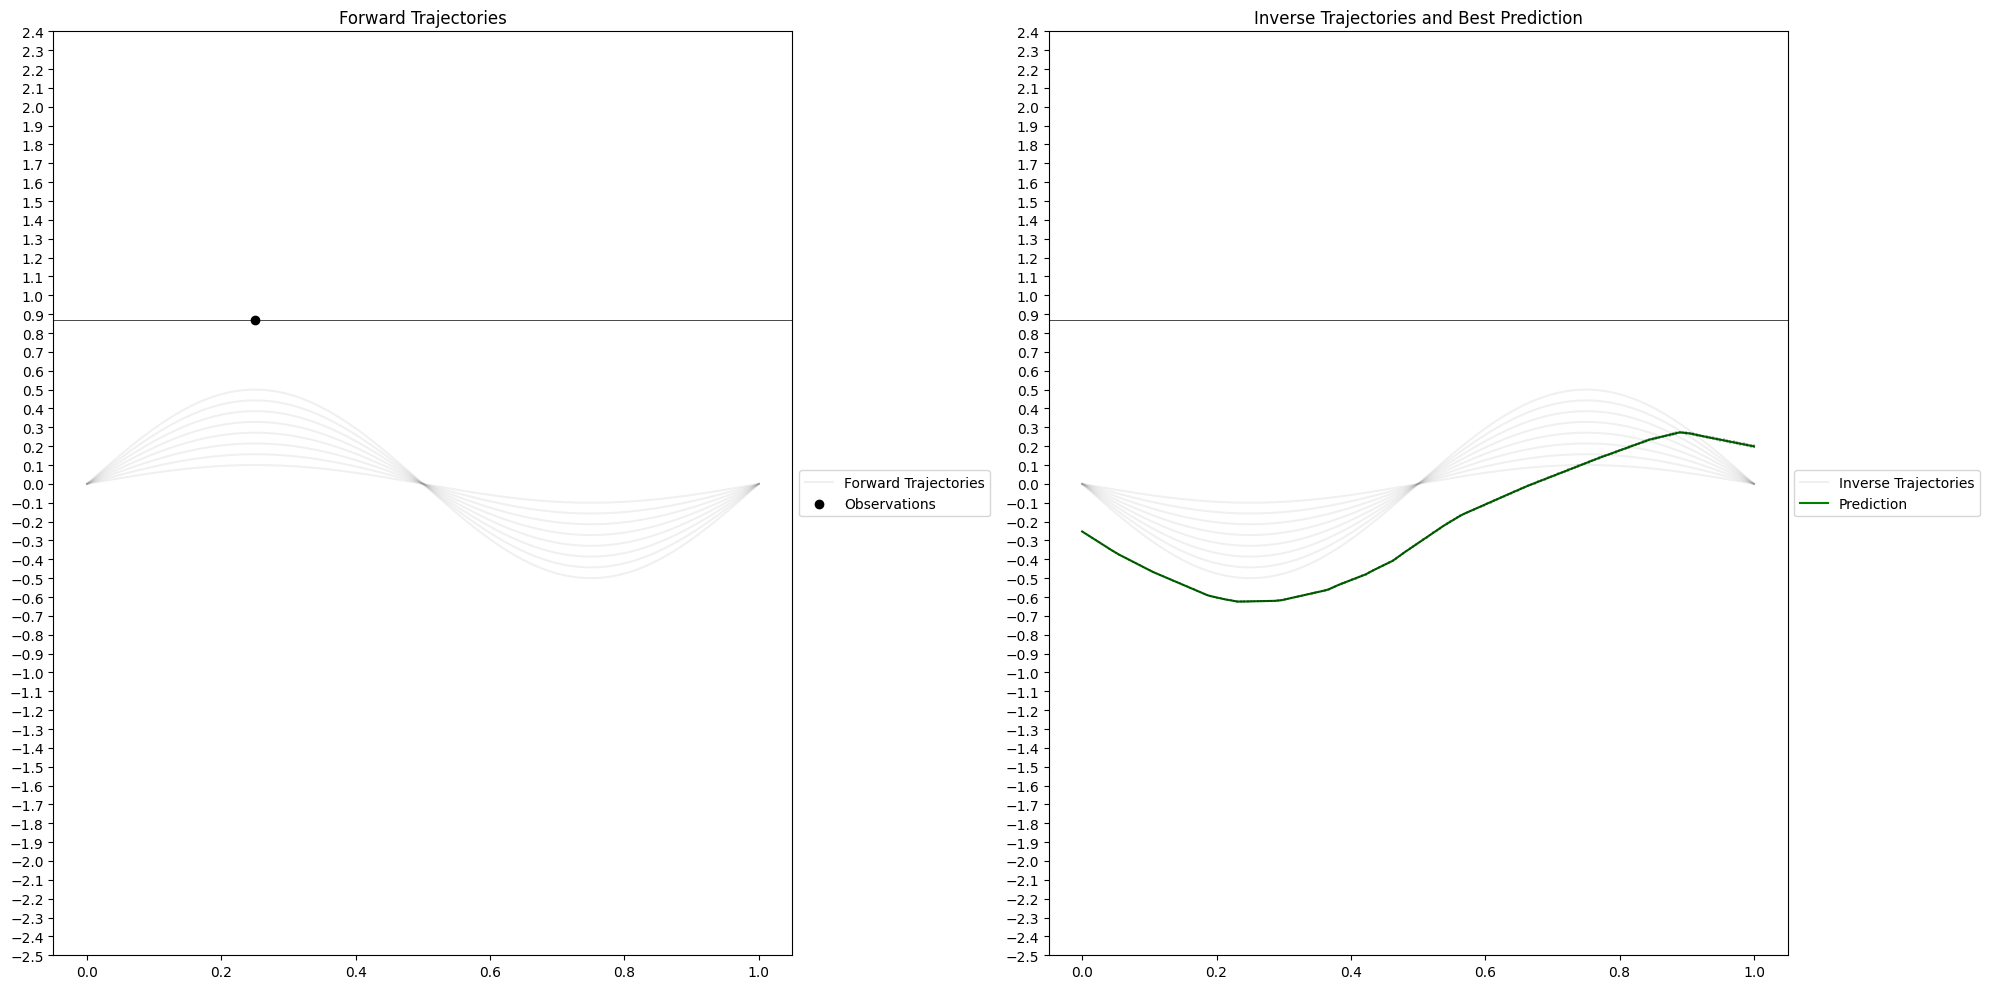

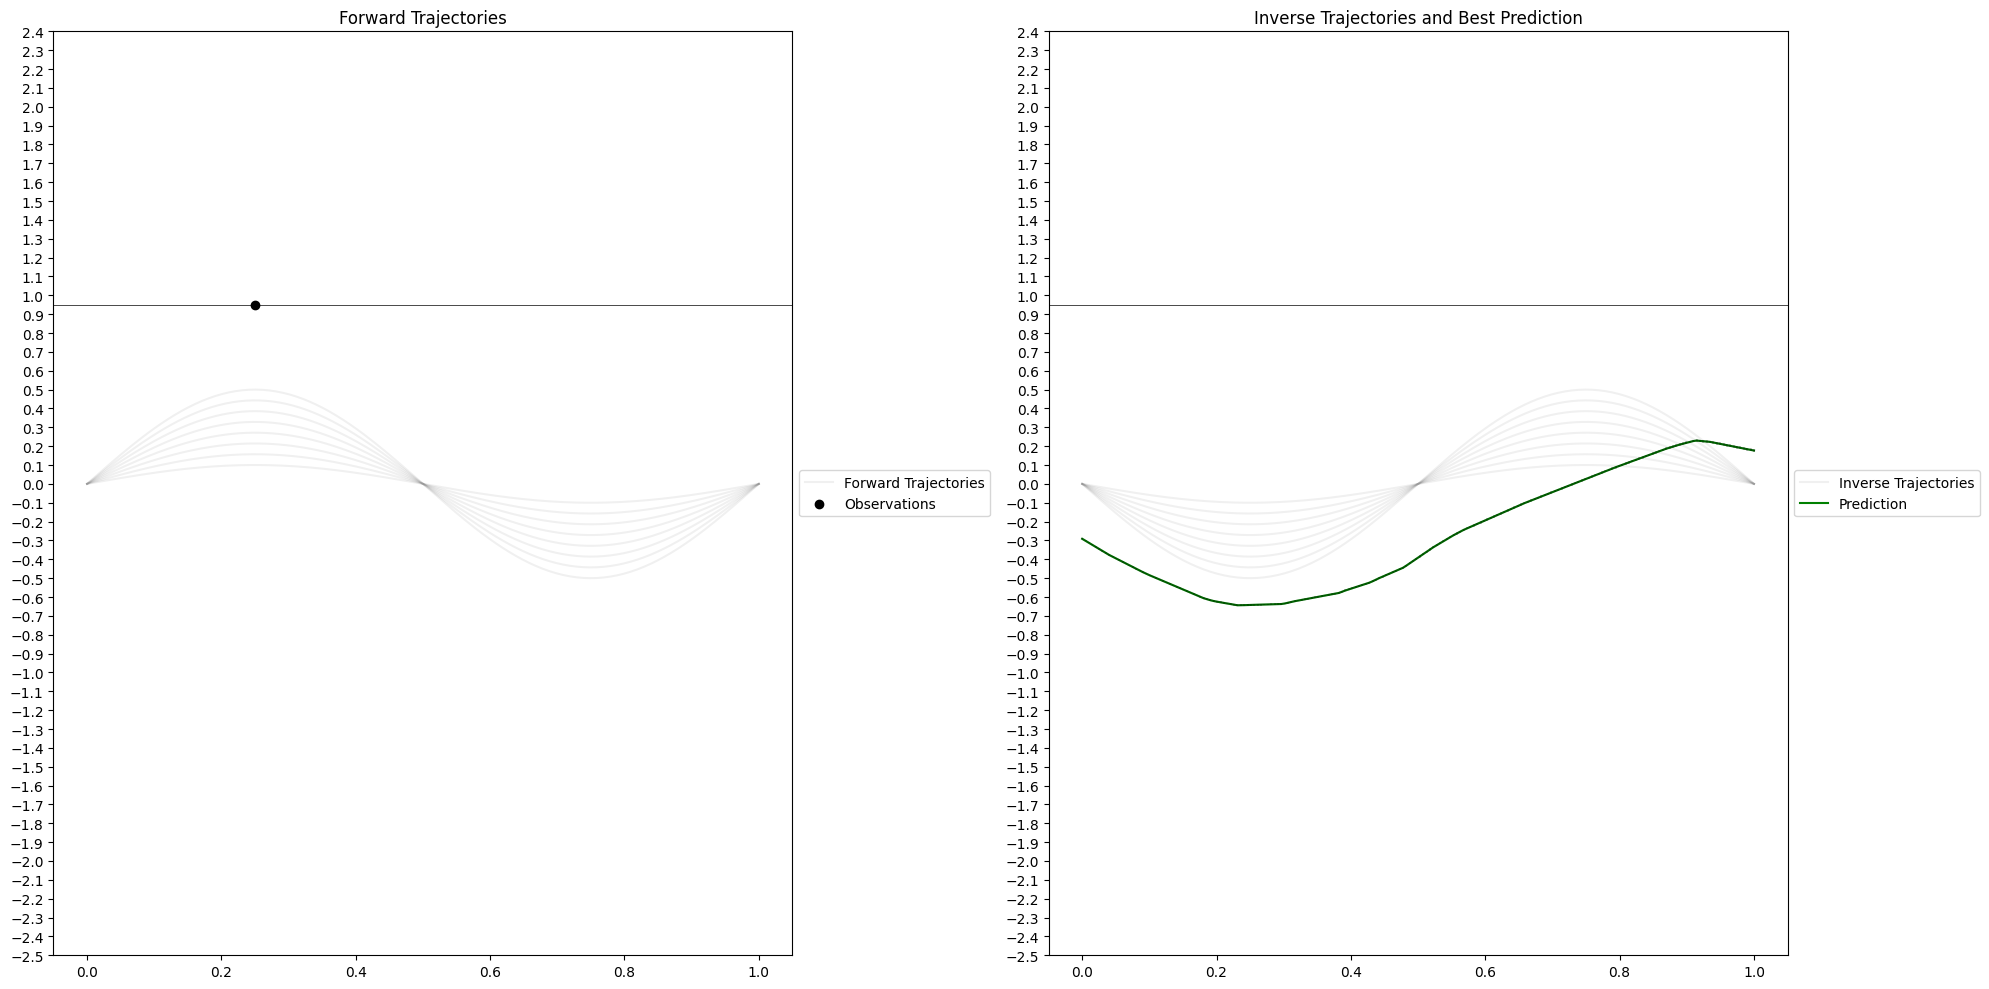

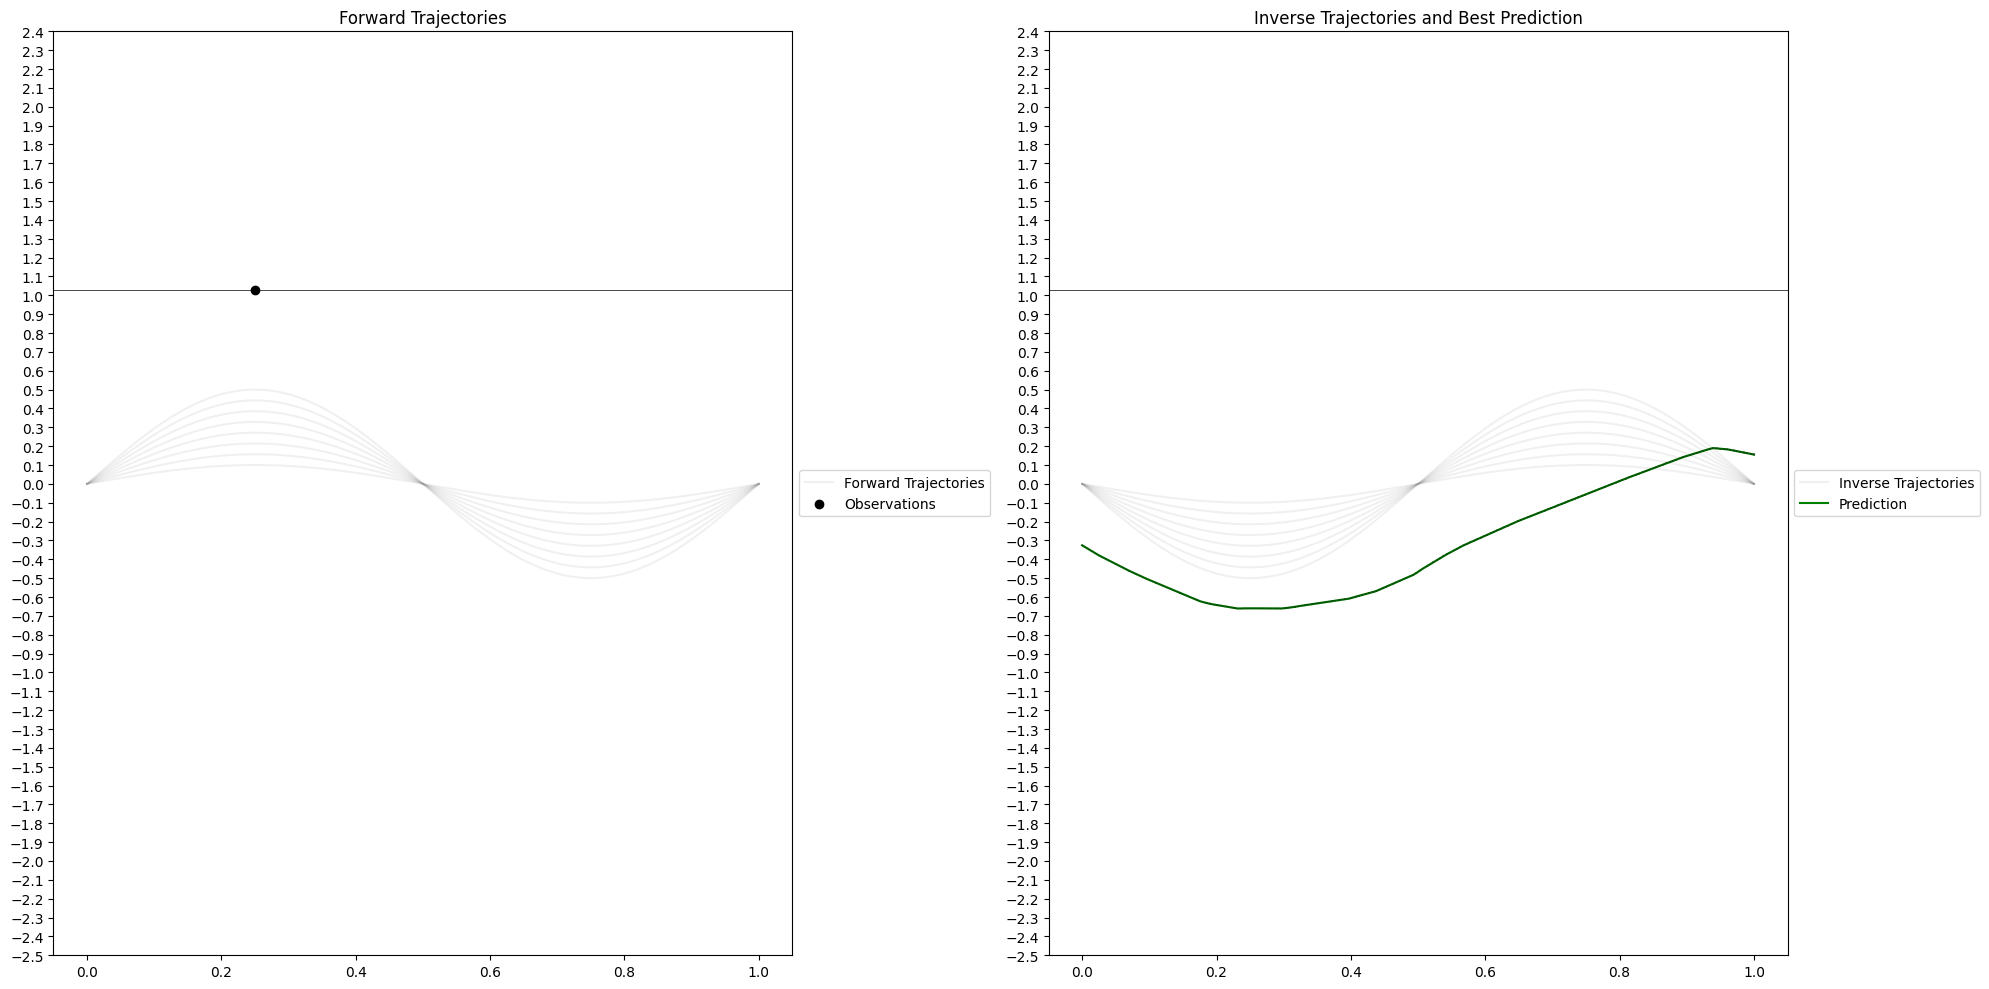

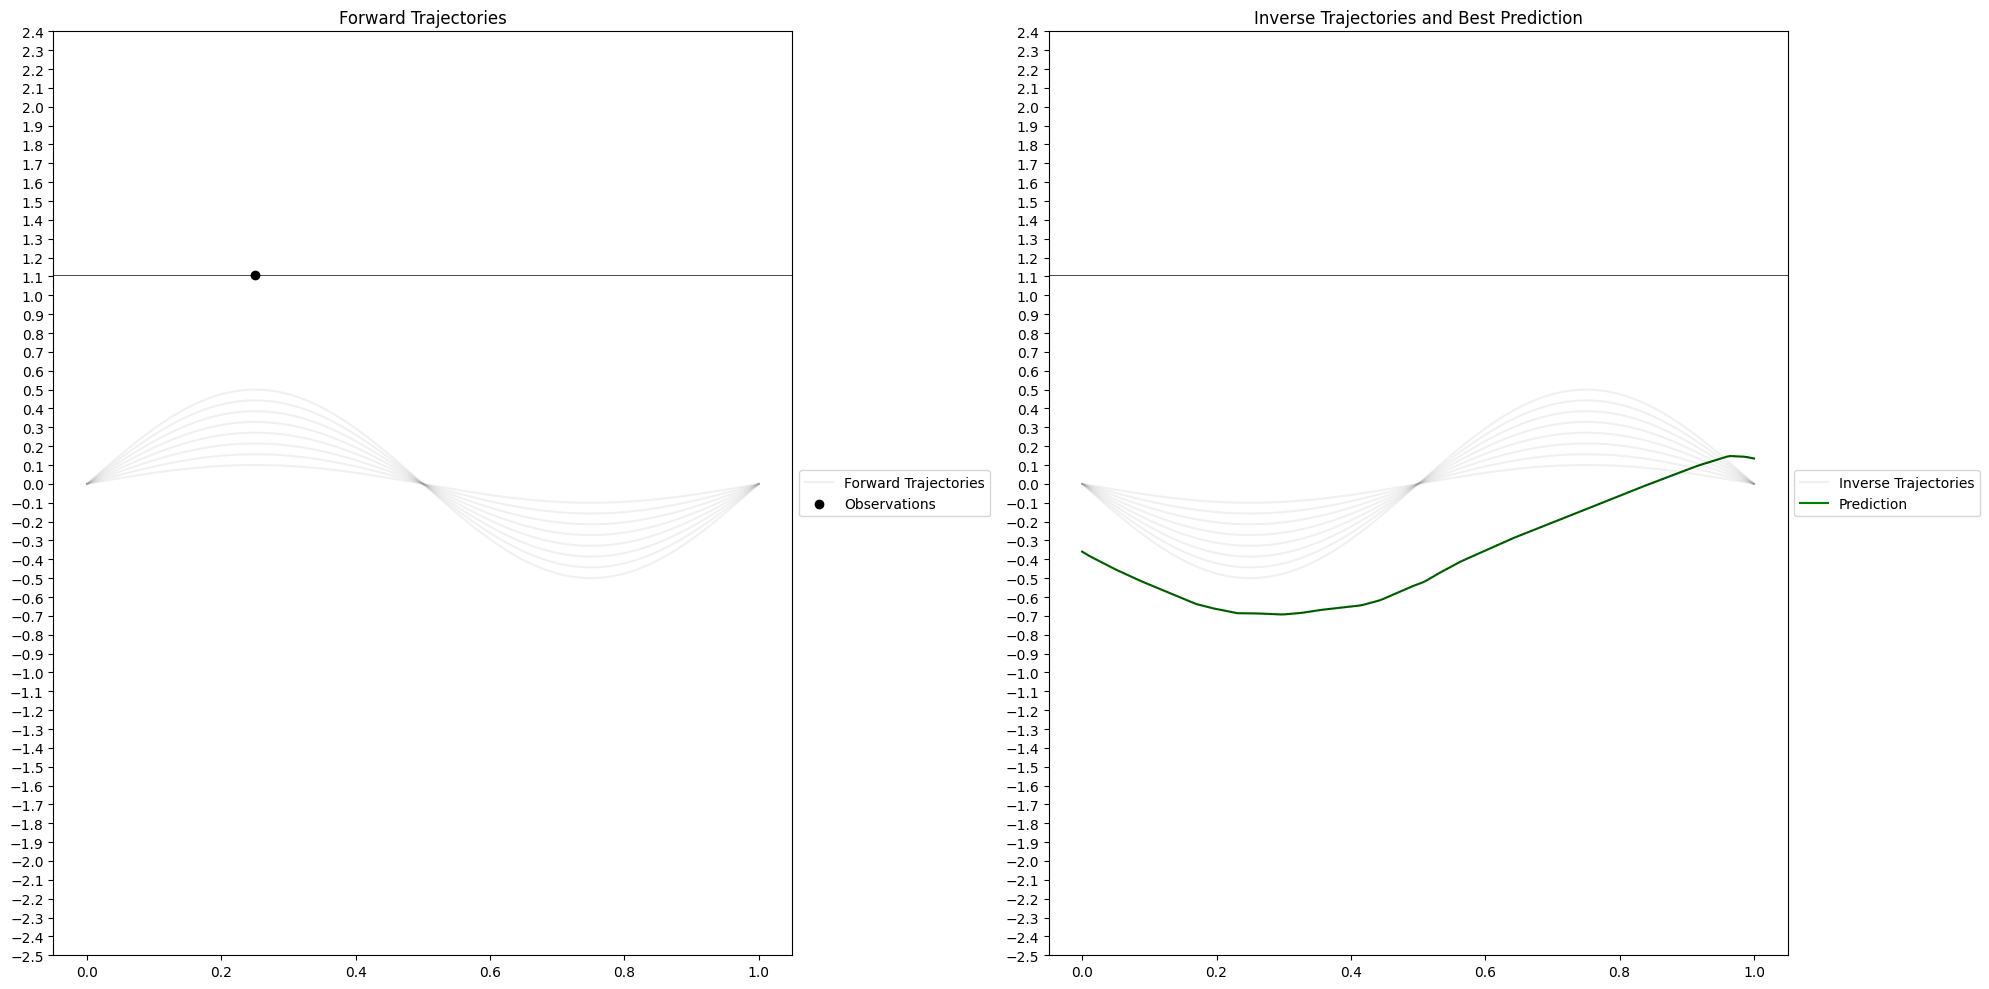

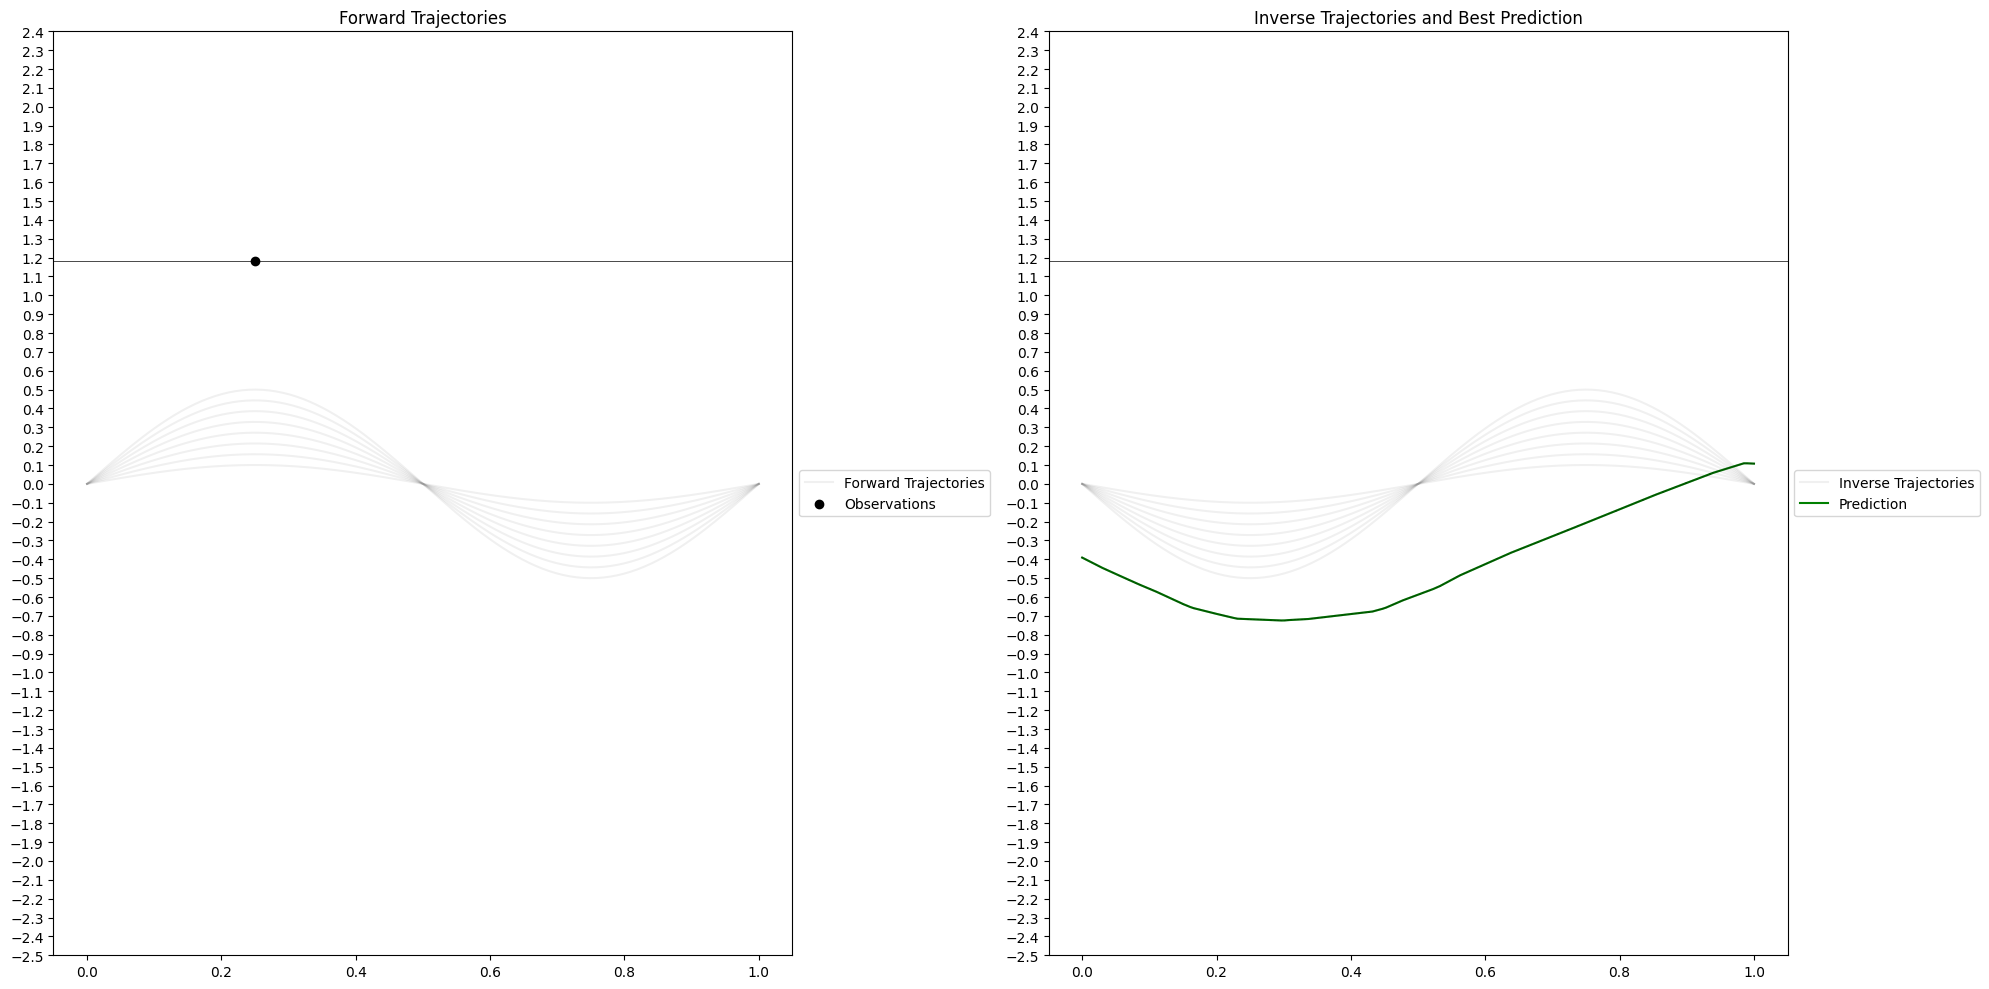

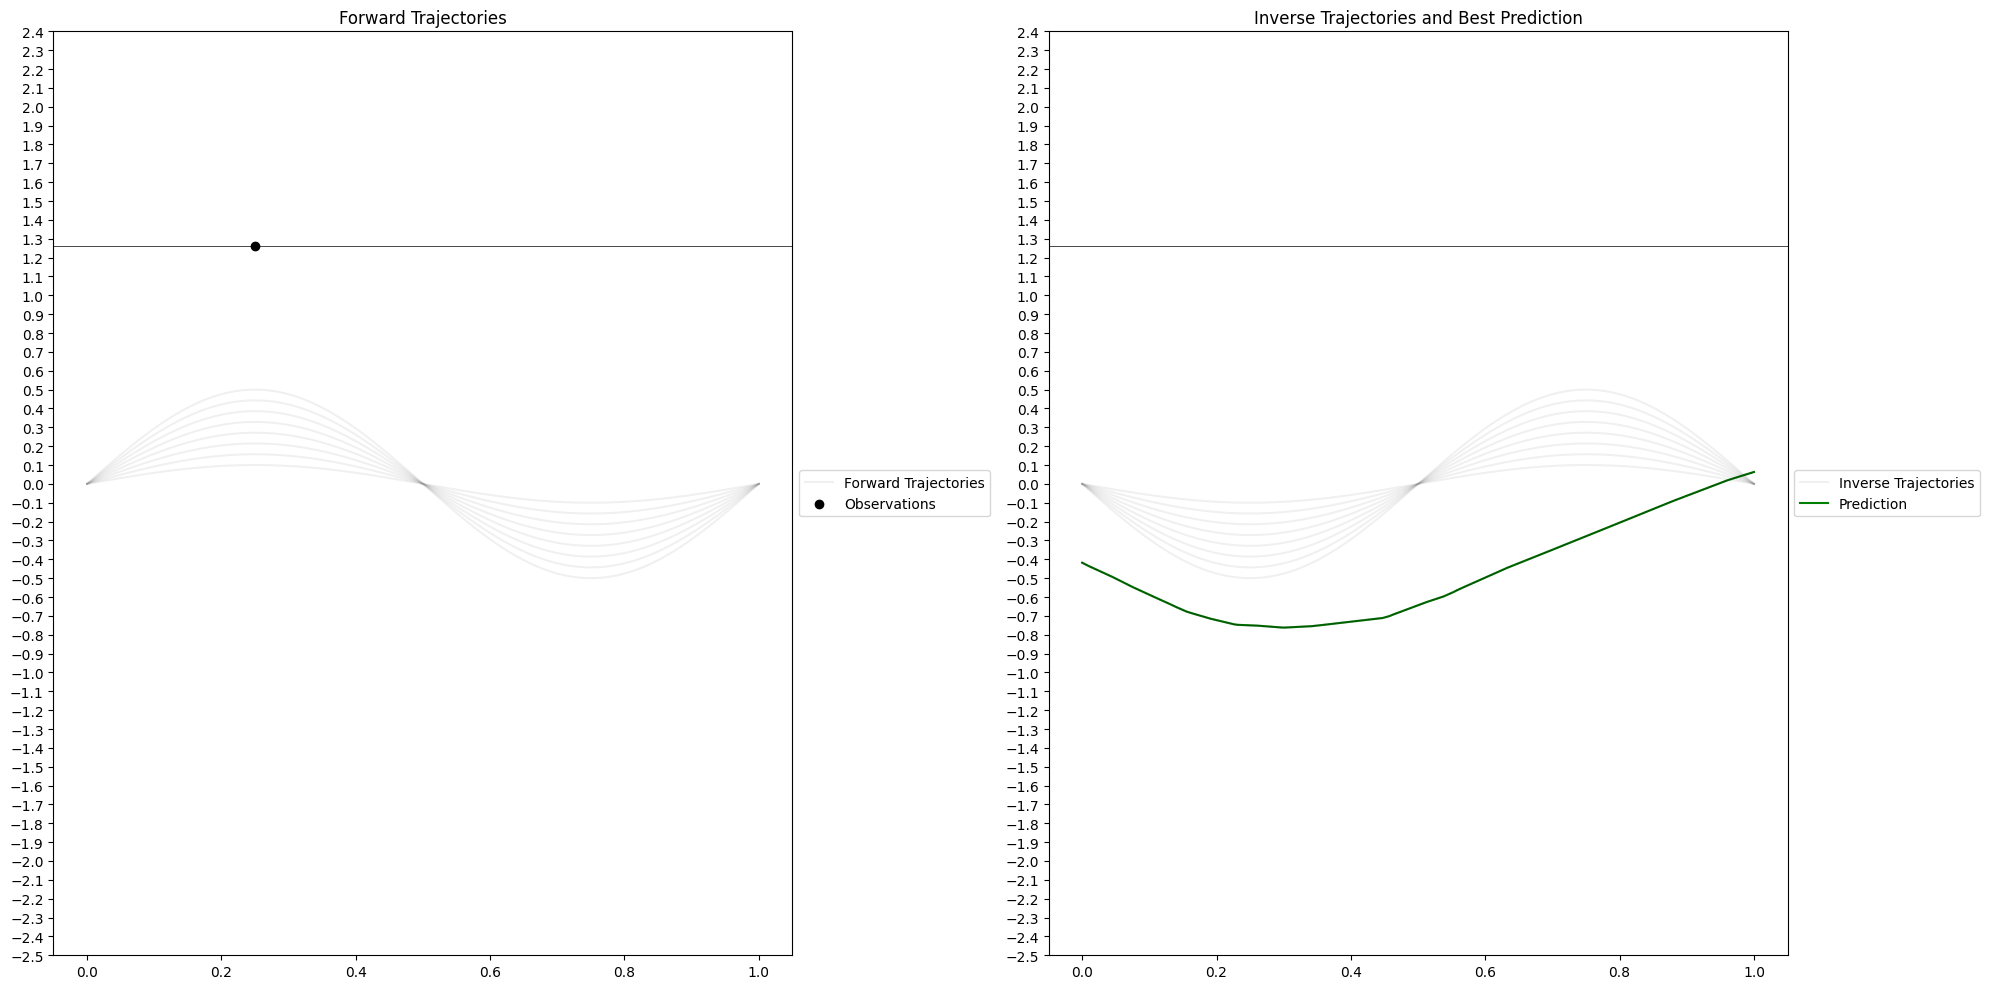

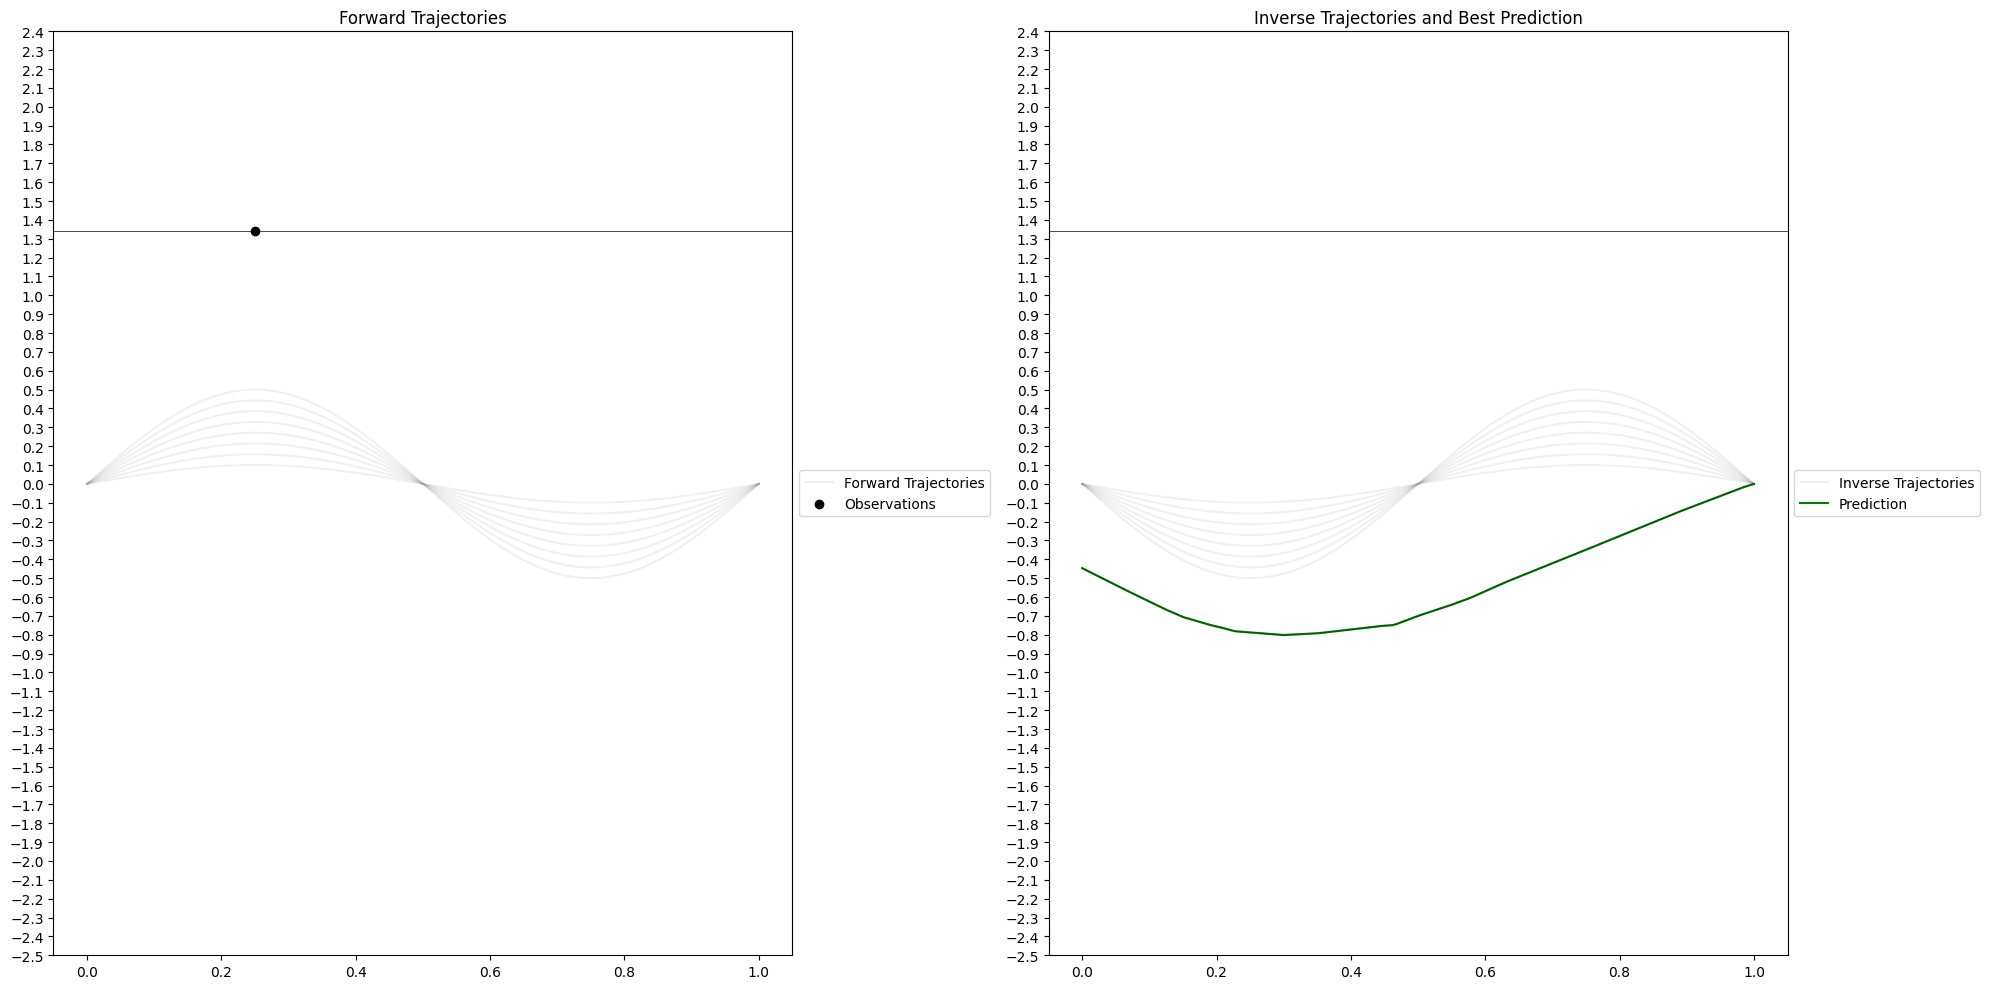

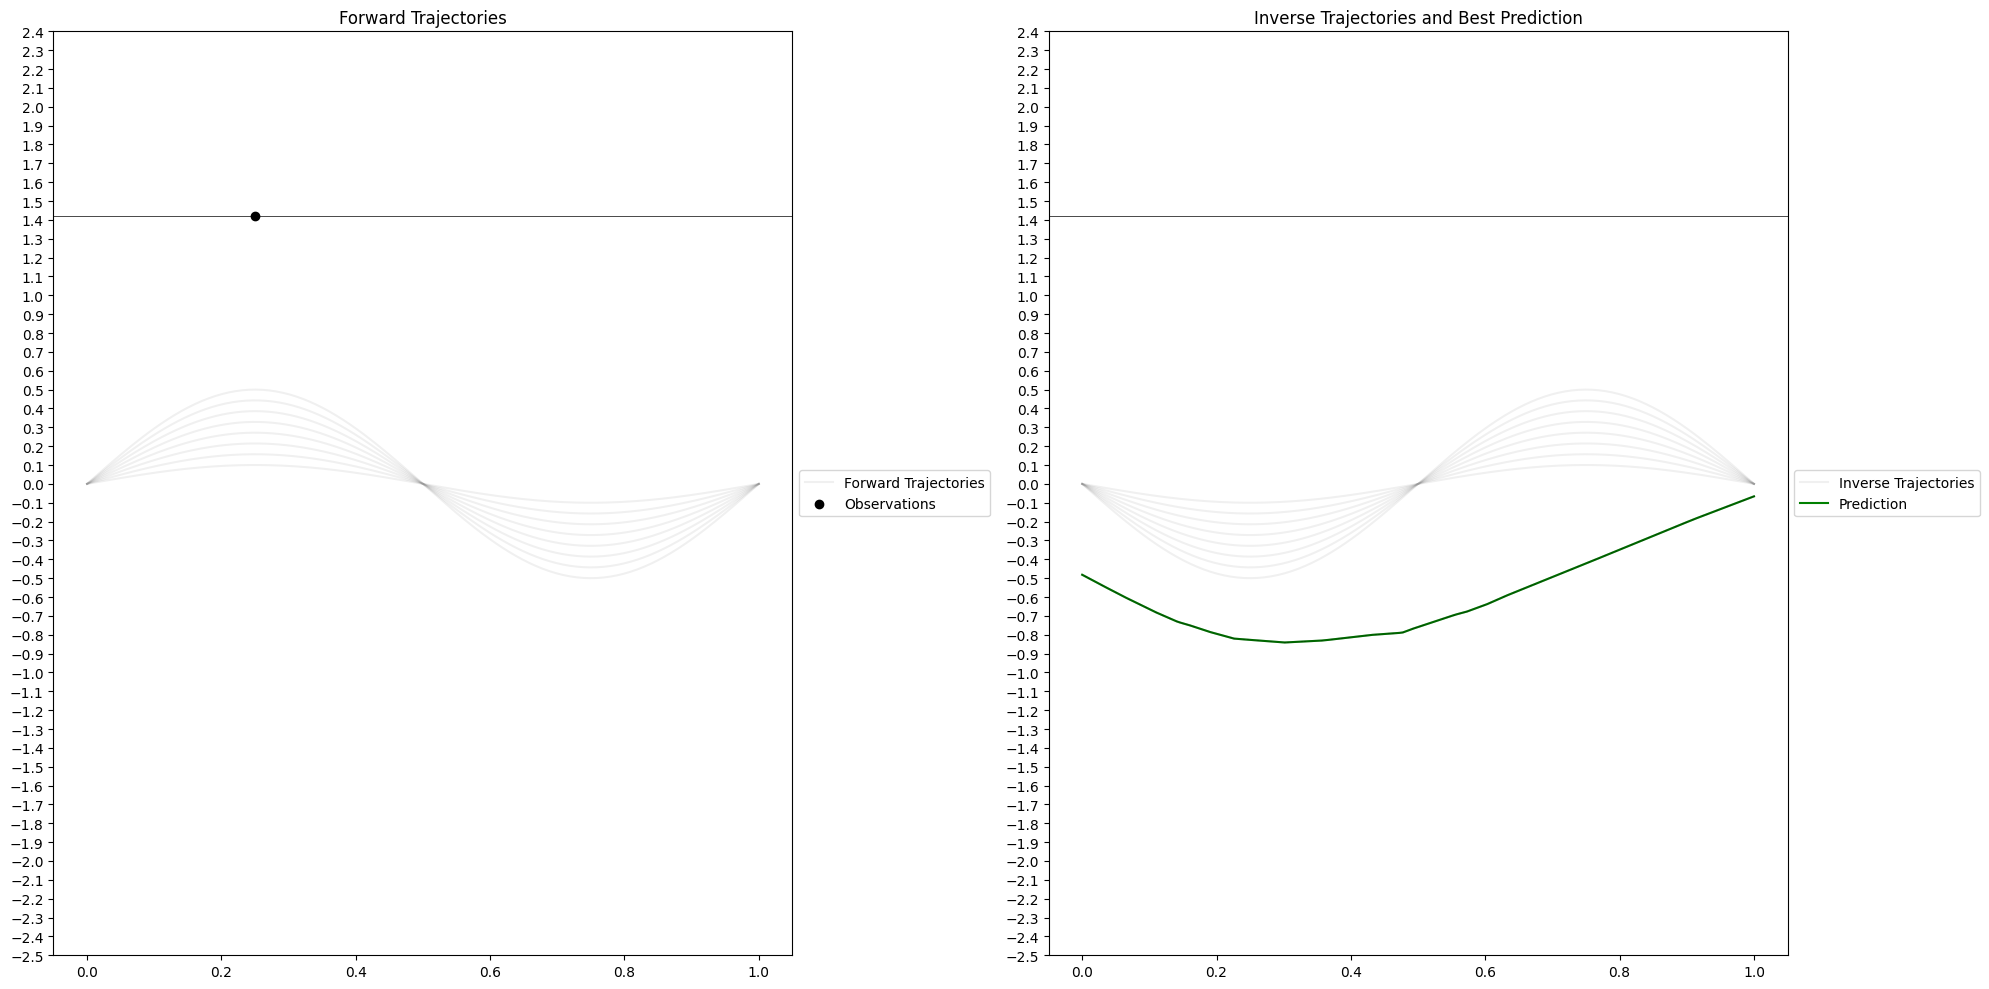

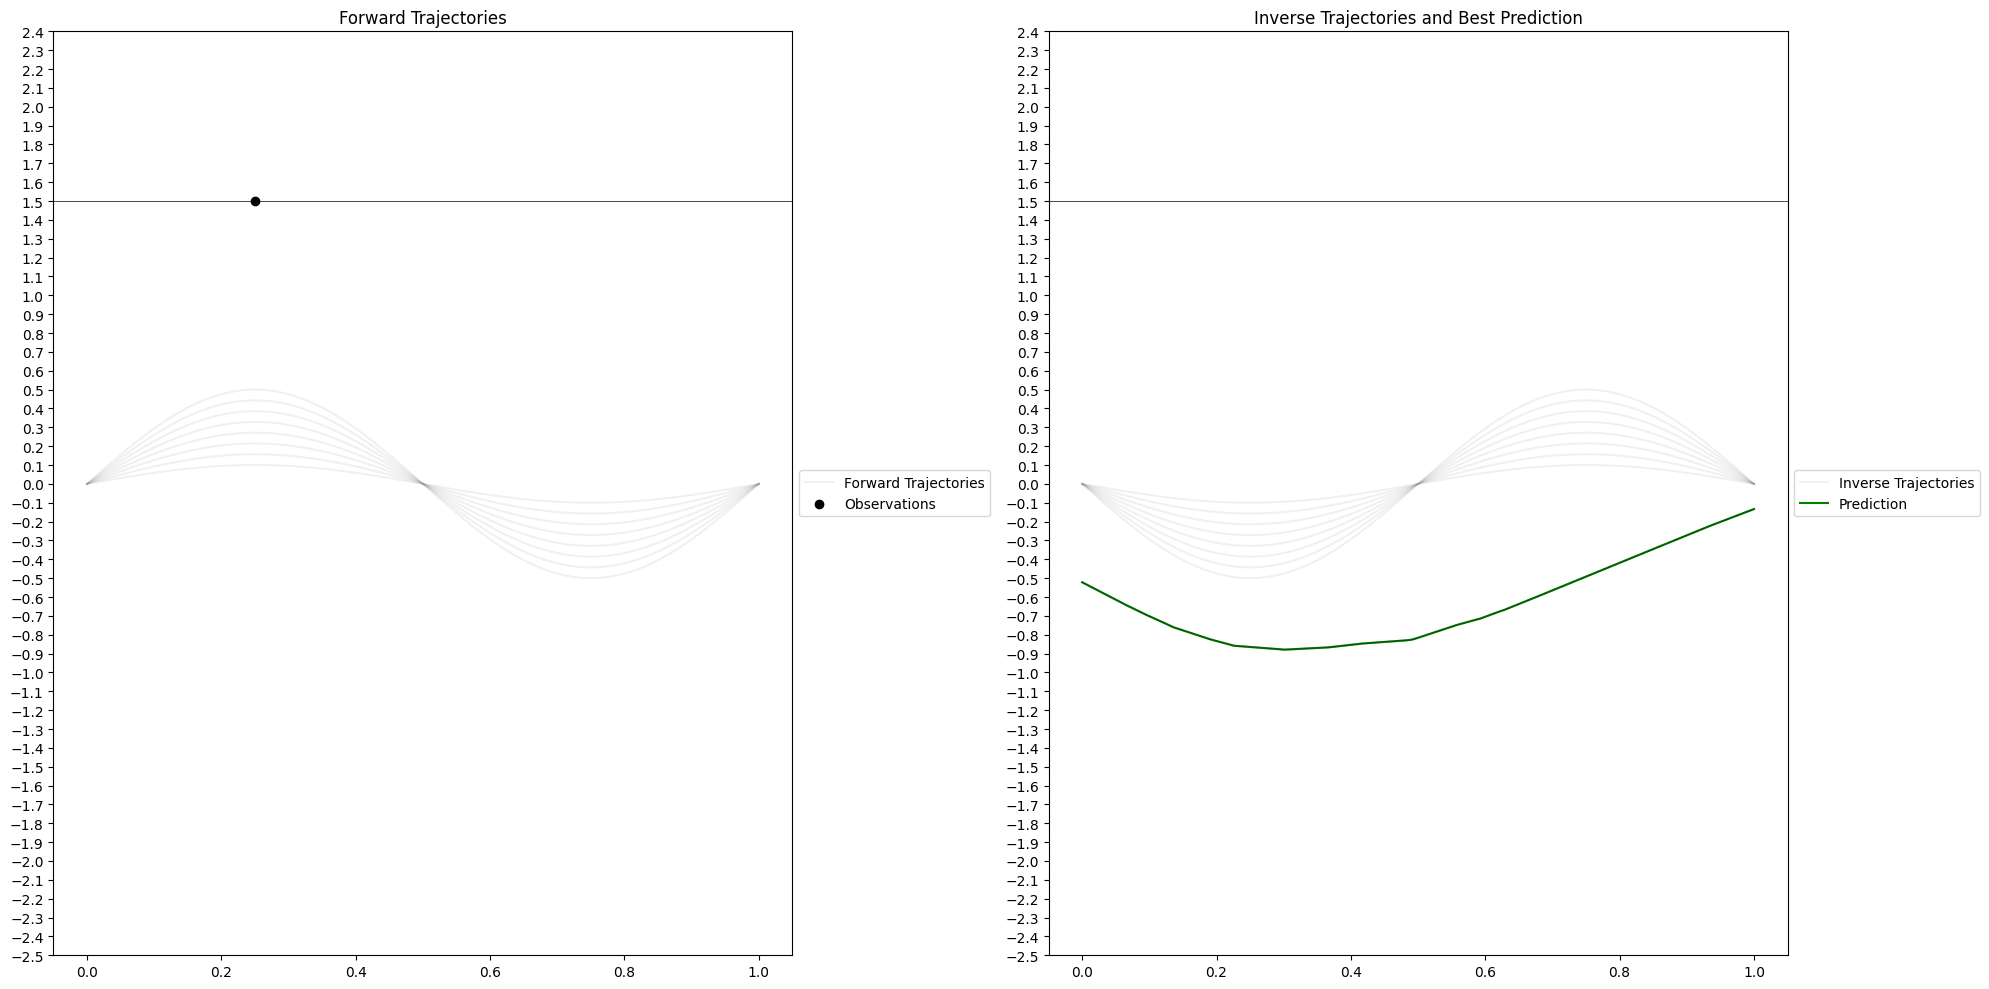

In [242]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

t = 0.25
min_y_f = torch.min(Y1[:, int(t * time_len)])
max_y_f = torch.max(Y1[:, int(t * time_len)])
interval_y_f = np.linspace(min_y_f-0.1, max_y_f+1, 20)

min_y_i = torch.min(Y2[:, int(t * time_len)])
max_y_i = torch.max(Y2[:, int(t * time_len)])
interval_y_i = torch.linspace(min_y_i-0.1, max_y_i+0.1, 20)

# plot latent losses
#plt.plot(errors_with_latent)
plt.show()

i = 0
for idx in interval_y_f:
    condition_points = [[t, torch.tensor([idx])]]
    means, stds = dual_enc_dec_cnmp.predict_inverse(best_model, 1, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
    if i == 0:
        utils.plot_results(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = True)
        i += 1
    utils.plot_results(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = False)

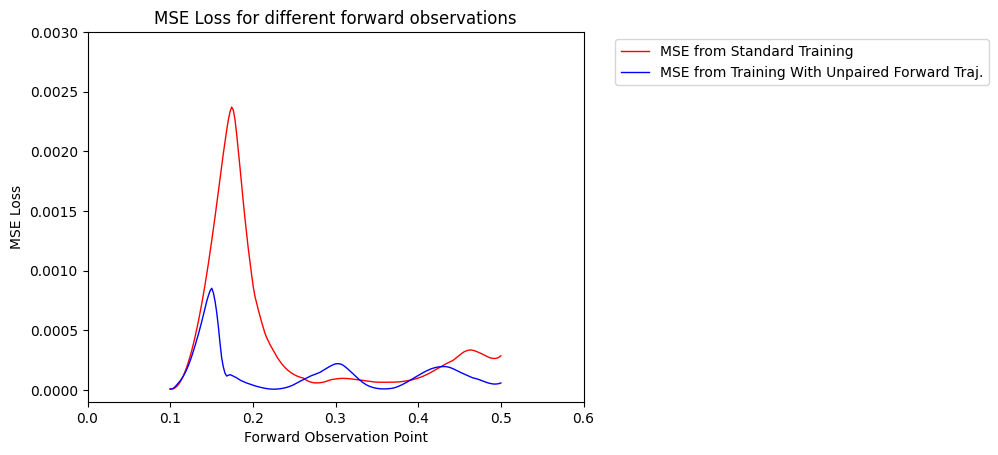

In [284]:

def sinx(frequency, amplitude, phase):
    def dist(x):
        return amplitude * math.sin(2 * torch.pi * frequency * x + phase) # + torch.randn(1) * 0.05
    return dist

interval_y_f_1 = np.linspace(0.1, 0.5, 200)

frequencies = [1, 1.75, 2.5]
amplitudes = np.linspace(0.1,0.5, 200)
phases = [0]  # Example phases

mse = []
for i in range(len(interval_y_f_1)):
    condition_points = [[0.25, torch.tensor([interval_y_f_1[i]])]]
    means, stds = dual_enc_dec_cnmp.predict_inverse(best_model, 1, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
    dist1 = sinx(frequencies[0], amplitudes[i], phases[i % len(phases)])
    expected_dist = [dist1(t) for t in np.linspace(0, 1, time_len)]
    expected_dist = torch.tensor(expected_dist)
    expected_dist = torch.flip(expected_dist, dims=[0])
    mse.append(F.mse_loss(means, expected_dist))

mse = np.array(mse)
mse_generalization = np.load('mse_generalization.npy')
#mse_general_without_latent = np.load('mse_generalization_without_latent_loss.npy')

plt.plot(interval_y_f_1, mse, label='MSE from Standard Training', linewidth=1, c='r')
plt.plot(interval_y_f_1, mse_generalization, label='MSE from Training With Unpaired Forward Traj.', linewidth=1,c='b')
#plt.plot(interval_y_f, mse_general_without_latent, label='MSE from Training With Unpaired Forward Traj., Without Latent Loss', linewidth=1,c='orange')
#plt.vlines(0.993, -1, 20, color='black', label='Max of Paired Data', linestyles='dashed')
#plt.vlines(0.24, -1, 20, color='gray', label='Min of Paired Data', linestyles='dashed')
#plt.vlines(1.24, -1, 20, color='green', label='Max of Unpaired Forward Data', linestyles='dashed')
plt.title('MSE Loss for different forward observations')
plt.ylim(-0.0001, 0.003)
plt.xlim(0,0.6)
plt.xlabel('Forward Observation Point')
plt.ylabel('MSE Loss')



## fill between vertical lines
#plt.fill_between([0.24, 0.99], -1, 20, color='gray', alpha=0.3, label='Paired Data Range')
#plt.fill_between([0.99, 1.24], -1, 20, color='green', alpha=0.3, label='Unpaired Data Range')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
